# Tiền xử lí dữ liệu

## Giới thiệu

Notebook này bao gồm các bước tiền xử lý dữ liệu để chuẩn bị cho việc phân tích và xây dựng mô hình dự đoán giá xe.

## Mục tiêu

- Dự đoán giá xe (regression) với độ chính xác cao nhất
- Target variable: `price_million`
- Input: 14,526 xe từ 2 nguồn (Chotot: 4,563 + BonBanh: 9,963)
- Output: 14,526 xe (không có outliers bị loại bỏ)

## Pipeline xử lý

```
Phase I: Đánh giá dữ liệu thô
├── 1.1 Khám phá cấu trúc dữ liệu Chotot (4,563 xe)
├── 1.2 Khám phá cấu trúc dữ liệu BonBanh (9,963 xe)
└── 1.3 Tổng hợp kế hoạch xử lý

Phase II: Chuẩn hóa dữ liệu
├── 2.1 Parse price -> price_million
├── 2.2 Parse km, handle placeholders
├── 2.3 Parse year
├── 2.4 Extract brand/model từ BonBanh title
├── 2.5 Extract engine từ nhiên liệu
├── 2.6 Chuẩn hóa categorical (transmission, fuel_type, body_type, origin, condition)
├── 2.7 Parse seats
├── 2.8 Extract city từ location
├── 2.9 Chuẩn hóa dtype
├── 2.10 Merge datasets → 14,526 xe
├── 2.11 Create early features (age, km_per_year)
└── 2.12 Loại bỏ duplicates (dựa trên seller_id, brand, model, year, km, price, transmission, fuel_type, body_type, city)

Phase III: Xử lý Outliers
├── 3.1 Khám phá phân phối dữ liệu số
├── 3.2 Xác định ngưỡng IQR
├── 3.3 Xác định ngưỡng thực tế (Domain Knowledge)
├── 3.4 Xem xét các outliers (giá < 50tr, giá > 15 tỷ, km > 500k)
├── 3.4a Xem xét outliers dựa trên km_per_year
└── 3.5 Loại bỏ outliers (nếu có)

Phase IV: Xử lý Missing Values
├── 4.1 Đánh giá missing values hiện tại
├── 4.2 Chiến lược xử lý
├── 4.3 Imputation functions
├── 4.4 Thực hiện imputation (body_type, seats, transmission, origin, km, year)
└── 4.5 Validation

Phase V: Feature Engineering
├── 5.1 age, km_per_year (đã tạo ở 2.11)
├── 5.2 is_luxury (2,723 xe sang = 18.7%)
└── 5.3 usage_intensity (low: 53.8%, medium: 36.0%, high: 10.1%)

Phase VI: Encoding
├── 6.1 One-hot Encoding (transmission, usage, fuel_type, origin, condition, source, body_type)
├── 6.2 Group + One-hot (brand, city)
└── 6.3 Target Encoding (model: 1400 values)

Phase VII: Lưu Dataset
├── 7.1 Xóa các cột categorical đã encode
└── 7.2 Export preprocessed_car_features.csv (14,526 rows × 71 cols)
```

### Import thư viện cần thiết

In [500]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import re
import os
from sklearn.model_selection import KFold
from unidecode import unidecode
from datetime import datetime

CURRENT_YEAR = 2025

### Load datasets

In [501]:
df_chotot = pd.read_csv("../datasets/raw_chotot_car_features.csv")
df_bonbanh = pd.read_csv("../datasets/raw_bonbanh_car_features.csv")

### I. Đánh giá dữ liệu thô

#### Chotot

In [502]:
df_chotot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4909 entries, 0 to 4908
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   title                4909 non-null   object 
 1   price                4909 non-null   object 
 2   Số Km đã đi          4691 non-null   float64
 3   Xuất xứ              4909 non-null   object 
 4   Tình trạng           4909 non-null   object 
 5   Chính sách bảo hành  4909 non-null   object 
 6   Hãng                 4909 non-null   object 
 7   Dòng xe              4909 non-null   object 
 8   Năm sản xuất         4909 non-null   object 
 9   Hộp số               4909 non-null   object 
 10  Nhiên liệu           4909 non-null   object 
 11  Kiểu dáng            3930 non-null   object 
 12  Số chỗ               4302 non-null   object 
 13  Trọng lượng          4691 non-null   object 
 14  Trọng tải            4691 non-null   object 
 15  location             4880 non-null   o

- Dataset có 4909 samples, 19 features, hầu hết các cột có dtype là object, trừ cột Km
- Cần chuyển các cột về đúng định dạng `numerical/categorial`

In [503]:
df_chotot.head()

,title,price,Số Km đã đi,Xuất xứ,Tình trạng,Chính sách bảo hành,Hãng,Dòng xe,Năm sản xuất,Hộp số,Nhiên liệu,Kiểu dáng,Số chỗ,Trọng lượng,Trọng tải,location,seller_id,Số đời chủ,Có phụ kiện đi kèm,Còn hạn đăng kiểm
0,Toyota Wigo 2020 1.2 số sàn màu đỏ nguyên zin,210.000.000 đ,200000.0,Nước khác,Đã sử dụng,Bảo hành hãng,Toyota,Wigo,2020,Số sàn,Xăng,Hatchback,5,> 1 tấn,> 2 tấn,"Phường 5, Quận 5, Tp Hồ Chí Minh",bf8ec81ff74b13e68547baef01123083,NaN,NaN,NaN
1,161 2017 LT 2.5L 4x2 MT - 160 km,295.000.000 đ,160.0,Thái Lan,Đã sử dụng,Bảo hành hãng,Chevrolet,Colorado,2017,Số sàn,Dầu,Pick-up (bán tải),5,> 1 tấn,> 2 tấn,"Phường 6, Quận 8, Tp Hồ Chí Minh",3555f5e4f94d1553395b639630ea6ce1,1 chủ,NaN,NaN
2,VinFast VF6 2024 S - 14000 km,589.000.000 đ,14000.0,Việt Nam,Đã sử dụng,Bảo hành hãng,VinFast,VF6,2024,Tự động,Điện,SUV / Cross over,5,> 1 tấn,> 2 tấn,"Phường Thạnh Xuân, Quận 12, Tp Hồ Chí Minh",7ed3e52ff9b6ad18a9cdb3f92c2b0e0e,1 chủ,NaN,NaN
3,Daewoo Gentra 2010 - 130000 km,105.000.000 đ,130000.0,Việt Nam,Đã sử dụng,Bảo hành hãng,Daewoo,Gentra,2010,Số sàn,Xăng,NaN,NaN,> 1 tấn,> 2 tấn,"Xã Đa Phước, Huyện Bình Chánh, Tp Hồ Chí Minh",fdde5dfa7299cd0d29b7cc2926b42a07,NaN,NaN,NaN
4,2017 XLS 2.2L 4x2 AT - 120 km,415.000.000 đ,120.0,Thái Lan,Đã sử dụng,Bảo hành hãng,Ford,Ranger,2017,Tự động,Dầu,Pick-up (bán tải),5,> 1 tấn,> 2 tấn,"Xã Bình Hưng, Huyện Bình Chánh, Tp Hồ Chí Minh",4c8bf38251a85124c7a32597682fbca1,NaN,NaN,NaN


**Nhận xét các cột sẽ GIỮ LẠI:**

- `price`: Chuỗi với dấu phân nghìn `.` và hậu tố `đ` (ví dụ: `320.000.000 đ`). Parse về đơn vị triệu đồng.

- `Hãng`, `Dòng xe`: Đã có sẵn, chỉ cần chuẩn hóa tên.

- `Số Km đã đi`: Số nguyên, có placeholder `999999` cần xử lý thành NaN.

- `Năm sản xuất`: Convert sang int, validate range hợp lệ.

- `Hộp số`: Categorical (`Tự động`/`Số sàn`/`Bán tự động`), cần chuẩn hóa.

- `Nhiên liệu`: Categorical (`Xăng`/`Dầu`/`Điện`/`Hybrid`).

- `Kiểu dáng`: Categorical, có 17% missing - cần impute.

- `Số chỗ`: Categorical, có 11% missing - cần impute.

- `Xuất xứ`, `Tình trạng`: Binary categorical.

- `location`: Parse để lấy `city`.

**Các cột sẽ thêm vào:**
- `engine`: Dung tích động cơ tách trực tiếp từ nhiên liệu

<Axes: >

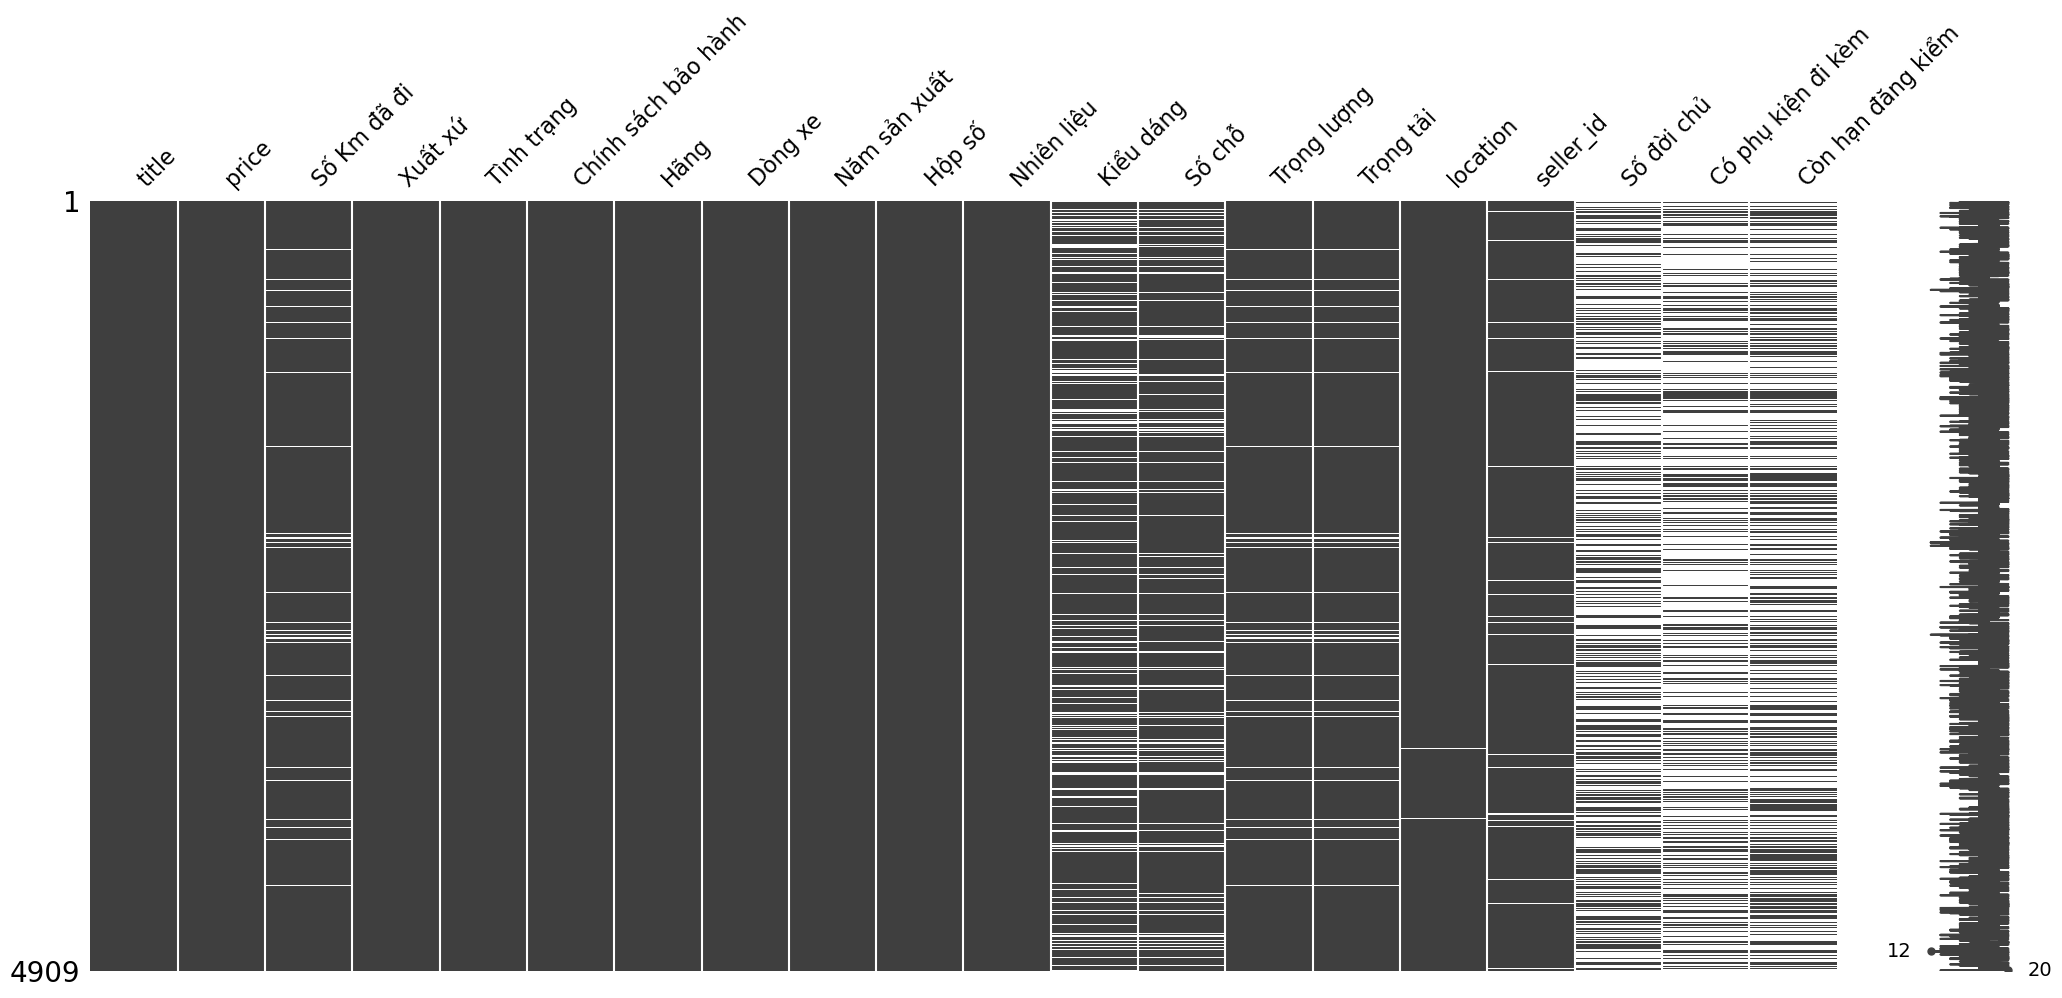

In [504]:
msno.matrix(df_chotot)

In [505]:
def get_numerical_summary(df):
    total = df.shape[0]
    missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
    missing_percent = {}
    for col in missing_columns:
        null_count = df[col].isnull().sum()
        per = (null_count/total) * 100
        missing_percent[col] = per
        print("{} : {} ({}%)".format(col, null_count, round(per, 3)))
    return missing_percent

In [506]:
chotot_missing_summary = get_numerical_summary(df_chotot)

Số Km đã đi : 218 (4.441%)
Kiểu dáng : 979 (19.943%)
Số chỗ : 607 (12.365%)
Trọng lượng : 218 (4.441%)
Trọng tải : 218 (4.441%)
location : 29 (0.591%)
seller_id : 186 (3.789%)
Số đời chủ : 2822 (57.486%)
Có phụ kiện đi kèm : 3270 (66.612%)
Còn hạn đăng kiểm : 2807 (57.181%)


**Phân loại theo tỷ lệ missing:**

| Cột | Missing | Quyết định |
|-----|---------|------------|
| `Số Km đã đi` | 4.4% | GIỮ - impute median |
| `Kiểu dáng` | 19.9% | GIỮ - impute theo brand+model |
| `Số chỗ` | 12.4% | GIỮ - impute theo body_type |
| `location` | 0.6% | GIỮ - fill "Khác" |
| `seller_id` | 3.8% | GIỮ - fill giá trị "0" - cột này chủ yếu để phát hiện samples trùng lặp|
| `Trọng lượng`, `Trọng tải` | 4.4% | BỎ - ít liên quan |
| `Còn hạn đăng kiểm` | 57.2% | BỎ - missing quá nhiều |
| `Số đời chủ` | 57.5% | BỎ - missing quá nhiều |
| `Có phụ kiện đi kèm` | 66.6% | BỎ - missing quá nhiều |

#### BonBanh

In [507]:
df_bonbanh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9983 entries, 0 to 9982
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           9983 non-null   object
 1   price           9983 non-null   object
 2   seller_id       9983 non-null   int64 
 3   Tình trạng      9983 non-null   object
 4   Năm sản xuất    9983 non-null   object
 5   Xuất xứ         9983 non-null   object
 6   Động cơ         9983 non-null   object
 7   Kiểu dáng       9983 non-null   object
 8   Hộp số          9983 non-null   object
 9   Số Km đã đi     9983 non-null   object
 10  Dẫn động        9983 non-null   object
 11  Màu ngoại thất  9983 non-null   object
 12  Màu nội thất    9983 non-null   object
 13  Số cửa          9983 non-null   object
 14  Số chỗ ngồi     9983 non-null   object
 15  location        9948 non-null   object
dtypes: int64(1), object(15)
memory usage: 1.2+ MB


- Dataset có 9,987 samples, 16 features - tất cả đều đang ở định dạng `object` (string) trừ seller_id
- Dữ liệu BonBanh có vẻ sạch hơn Chotot về mặt số lượng missing values
- Cần chuyển các cột về đúng định dạng `numerical/categorical`

In [508]:
df_bonbanh.head()

,title,price,seller_id,Tình trạng,Năm sản xuất,Xuất xứ,Động cơ,Kiểu dáng,Hộp số,Số Km đã đi,Dẫn động,Màu ngoại thất,Màu nội thất,Số cửa,Số chỗ ngồi,location
0,Xe VinFast VF8 Eco\t2025,890 Triệu,796475,Xe mới,2025,Trong nước,Điện,SUV,Số tự động,-,FWD - Dẫn động cầu trước,Trắng,Đen,5 cửa,5 chỗ,256 Kim Giang Hà Nội
1,Xe Lexus RX 350\t2016,2 Tỷ 90 Triệu,491083,Xe đã dùng,2016,Nhập khẩu,Xăng 3.5 L,SUV,Số tự động,"100,000 Km",AWD - 4 bánh toàn thời gian,Đen,Nâu,5 cửa,5 chỗ,"CT2 Văn Phòng Quốc Hội , Xuân Phương , Hà Nội ..."
2,Xe Peugeot 2008 GT Line 1.2 AT\t2022,645 Triệu,329142,Xe đã dùng,2022,Trong nước,Xăng 1.2 L,Crossover,Số tự động,"60,000 Km",FWD - Dẫn động cầu trước,Trắng,Đen,5 cửa,5 chỗ,"Số 5 Nguyễn Khánh Toàn, Cầu Giấy, Hà Nội. ( đố..."
3,Xe Toyota Corolla Cross 1.8HV\t2021,736 Triệu,641798,Xe đã dùng,2021,Nhập khẩu,Hybrid 1.8 L,SUV,Số tự động,"25,500 Km",FWD - Dẫn động cầu trước,Đỏ,Đỏ,5 cửa,5 chỗ,"220 Nguyễn Hữu Cảnh , P22, Q. Bình Thạnh TP HCM"
4,Xe Ford EcoSport Titanium 1.5L AT\t2019,378 Triệu,42194,Xe đã dùng,2019,Trong nước,Xăng 1.5 L,SUV,Số tự động,"79,000 Km",FWD - Dẫn động cầu trước,Bạc,Đen,5 cửa,5 chỗ,"132A Cổ Linh, Long Biên Hà Nội"


**Nhận xét các cột sẽ GIỮ LẠI:**

- `title`: Chứa hãng/tên xe/phiên bản/năm. Cần extract `brand` và `model`.

- `price`: Format `1 Tỷ 679 Triệu`, `498 Triệu`. Parse: `Tỷ` = 1000, `Triệu` = 1.

- `location`: Địa chỉ chi tiết, cần extract tỉnh/thành phố.

- `Tình trạng`: `Xe đã dùng`/`Xe mới` - binary.

- `Xuất xứ`: `Nhập khẩu`/`Trong nước` - binary.

- `Động cơ`: Chứa nhiên liệu và dung tích (ví dụ: `Xăng 2.0 L`). Chỉ extract `fuel_type`.

- `Kiểu dáng`: Sedan, SUV, Hatchback, etc.

- `Hộp số`: `Số tự động`/`Số tay`.

- `Số Km đã đi`: Format `6,900 Km`, xe mới có `-`. Parse về numeric.

- `Số chỗ ngồi`: Format `5 chỗ`, `7 chỗ`. Extract số.

<Axes: >

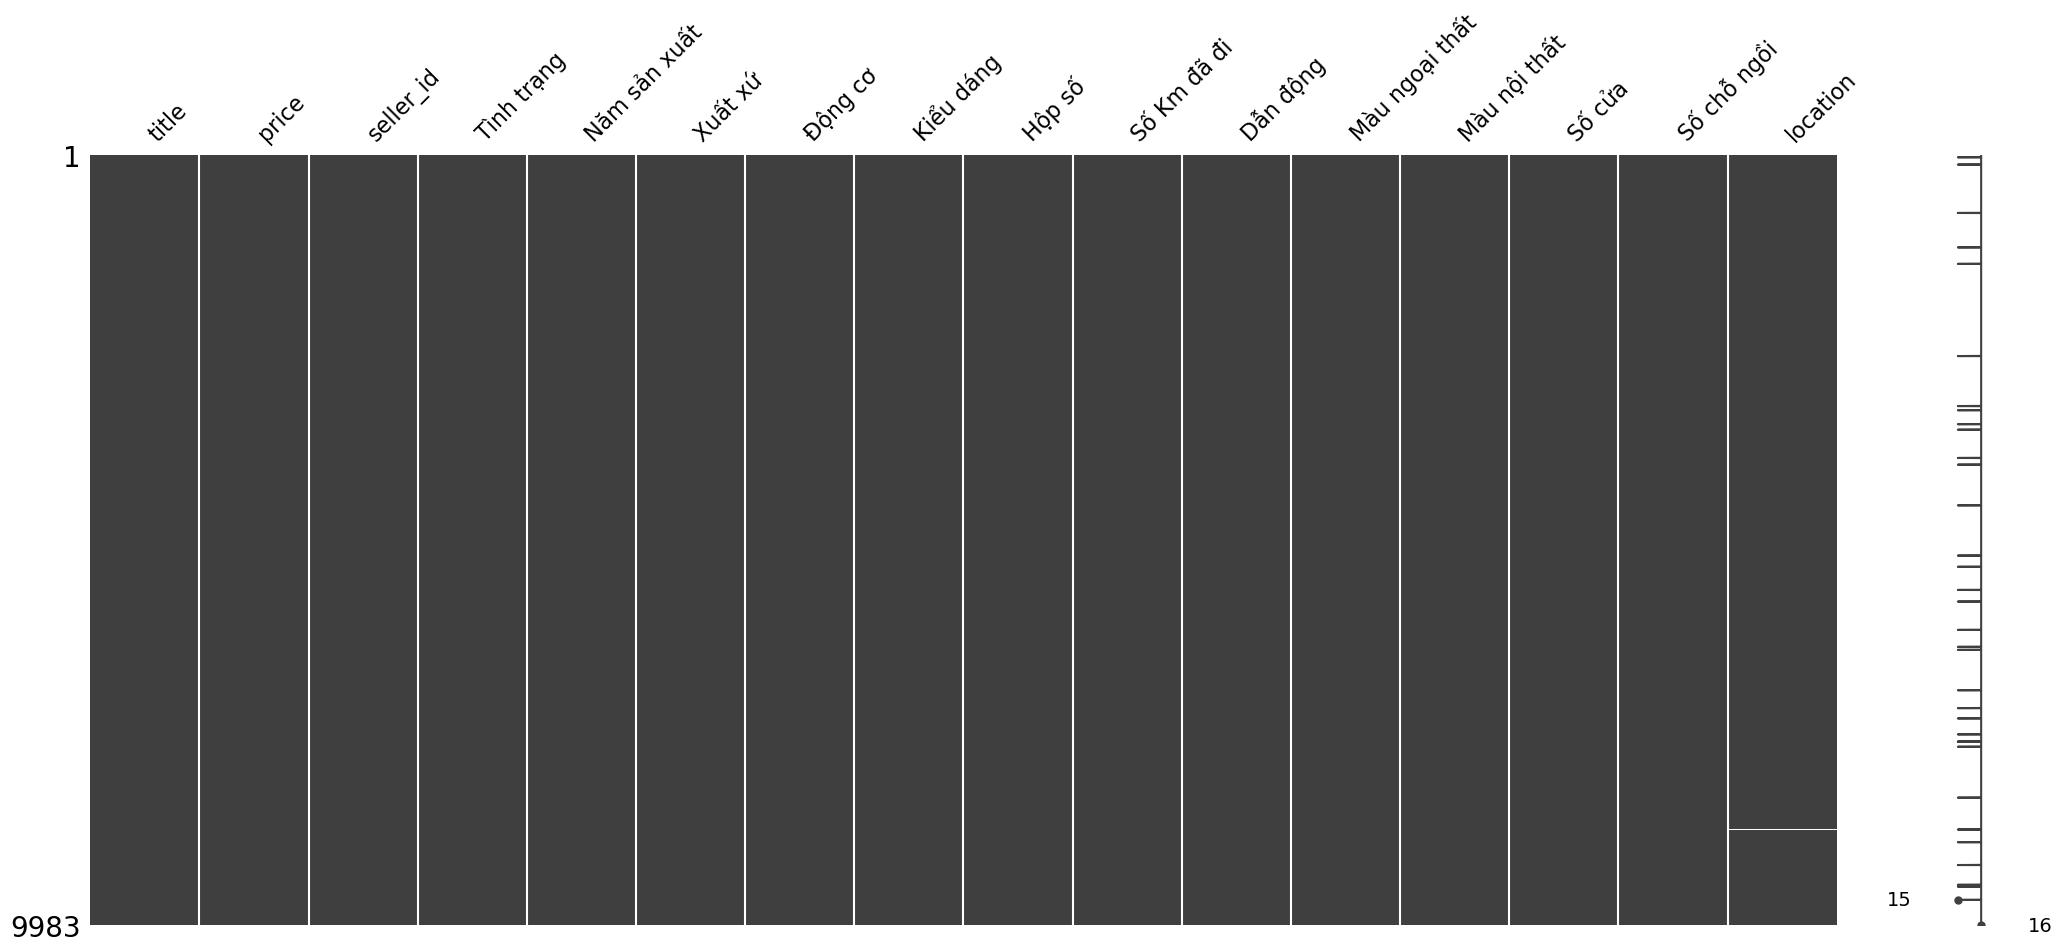

In [509]:
msno.matrix(df_bonbanh)

In [510]:
bonbanh_missing_summary = get_numerical_summary(df_bonbanh)

location : 35 (0.351%)


Dataset BonBanh có chất lượng rất cao với hầu như không có missing values:
- Chỉ có cột `location` có 35 giá trị thiếu (0.35%) - tỷ lệ cực thấp, có thể bỏ qua hoặc dễ dàng xử lý.
- Hầu hết các feature khác đều đầy đủ 100% dữ liệu.

### Tổng hợp kế hoạch xử lý


**Mục tiêu:** Dự đoán giá xe (regression) với độ chính xác cao nhất. Target: `price_million`

#### Quyết định về features

| Cột             | Chotot                  | BonBanh             | Xử lý                        |
|-----------------|-------------------------|---------------------|------------------------------|
| `brand`         | Hãng                    | Extract từ title    | Chuẩn hóa tên hãng           |
| `model`         | Dòng xe                 | Extract từ title    | Chuẩn hóa tên model          |
| `price_million` | Parse từ price          | Parse từ price      | Target variable              |
| `year`          | Năm sản xuất            | Năm sản xuất        | Convert int                  |
| `km`            | Số Km đã đi             | Số Km đã đi         | Parse, handle placeholders   |
| `transmission`  | Hộp số                  | Hộp số              | Chuẩn hóa: AT/MT             |
| `fuel_type`     | Nhiên liệu              | Tách từ Động cơ     | Chuẩn hóa categories         |
| `body_type`     | Kiểu dáng               | Kiểu dáng           | Impute theo brand+model      |
| `seats`         | Số chỗ                  | Số chỗ ngồi         | Impute theo body_type        |
| `origin`        | Xuất xứ                 | Xuất xứ             | Binary: Nhập khẩu/Trong nước |
| `condition`     | Tình trạng              | Tình trạng          | Binary: Mới/Đã dùng          |
| `city`          | Parse từ location       | Parse từ location   | Fill "unknow" nếu thiếu      |
| `engine`        | Tạo thêm missing_engine | Parse từ nhiên liệu | Fill "unknow" nếu thiếu      |

#### Các cột sẽ BỎ

**Chotot:**
- `seller` (100% missing)
- `Còn hạn đăng kiểm` (58% missing)
- `Số đời chủ` (57% missing)
- `Có phụ kiện đi kèm` (68% missing)
- `Chính sách bảo hành` (không ảnh hưởng giá)
- `Trọng lượng`, `Trọng tải` (ít liên quan)

**BonBanh:**
- `Màu ngoại thất`, `Màu nội thất` (ít ảnh hưởng giá, phức tạp)
- `engine_capacity` (không có ở Chotot, khó fill chính xác)
- `drivetrain` (không có ở Chotot, khó fill chính xác)
- `doors` (không có ở Chotot, ít quan trọng)

### II. Chuẩn hóa dữ liệu

#### 2.1 Parse price

In [511]:
def parse_chotot_price(price_str):
    """Parse Chotot price: '320.000.000 đ' -> 320"""
    if pd.isna(price_str):
        return np.nan
    nums = re.sub(r'[^\d]', '', str(price_str))
    return int(nums) / 1_000_000 if nums else np.nan

def parse_bonbanh_price(price_str):
    """Parse BonBanh price: '1 Tỷ 679 Triệu' -> 1679"""
    if pd.isna(price_str):
        return np.nan
    s = str(price_str)
    ty = re.search(r'(\d+)\s*Tỷ', s)
    trieu = re.search(r'(\d+)\s*Triệu', s)
    total = 0
    if ty:
        total += int(ty.group(1)) * 1000
    if trieu:
        total += int(trieu.group(1))
    return total if total > 0 else np.nan

df_chotot['price_million'] = df_chotot['price'].apply(parse_chotot_price)
df_bonbanh['price_million'] = df_bonbanh['price'].apply(parse_bonbanh_price)

In [512]:
df_chotot[['price', 'price_million']].head(10)

,price,price_million
0,210.000.000 đ,210.0
1,295.000.000 đ,295.0
2,589.000.000 đ,589.0
3,105.000.000 đ,105.0
4,415.000.000 đ,415.0
5,125.000.000 đ,125.0
6,700.000.000 đ,700.0
7,440.000.000 đ,440.0
8,579.000.000 đ,579.0
9,950.000.000 đ,950.0


In [513]:
df_bonbanh[['price', 'price_million']].head(10)

,price,price_million
0,890 Triệu,890
1,2 Tỷ 90 Triệu,2090
2,645 Triệu,645
3,736 Triệu,736
4,378 Triệu,378
5,415 Triệu,415
6,390 Triệu,390
7,1 Tỷ 20 Triệu,1020
8,180 Triệu,180
9,535 Triệu,535


#### 2.2 Xử lý số km đã đi

In [514]:
# Chotot: đã là numeric, chỉ cần xử lý placeholder (999999)
df_chotot['km'] = df_chotot['Số Km đã đi'].apply(
    lambda x: np.nan if pd.isna(x) or x >= 900000 else x
)

# BonBanh: parse string format '6,900 Km', '-' = xe mới
def parse_bonbanh_km(km_str):
    """Chuyển đổi chuỗi km BonBanh về số"""
    if pd.isna(km_str):
        return np.nan
    s = str(km_str).strip()
    if s == '-':
        return 0  # Xe mới chưa đi
    nums = re.sub(r'[^\d]', '', s)
    return int(nums) if nums else np.nan

df_bonbanh['km'] = df_bonbanh['Số Km đã đi'].apply(parse_bonbanh_km)
df_bonbanh['km'] = df_bonbanh['km'].apply(
    lambda x: np.nan if pd.isna(x) or x >= 900000 else x
)

print("Chotot km:", df_chotot['km'].describe())
print("\nBonBanh km:", df_bonbanh['km'].describe())

Chotot km: count      4669.000000
mean      99602.023560
std      106236.165729
min           0.000000
25%       30000.000000
50%       80000.000000
75%      128000.000000
max      896000.000000
Name: km, dtype: float64

BonBanh km: count      9978.000000
mean      43103.000601
std       48506.691599
min           0.000000
25%           0.000000
50%       35000.000000
75%       70000.000000
max      820000.000000
Name: km, dtype: float64


#### 2.3 Xử lý năm sản xuất

In [515]:
def parse_year(year_val):
    """Chuyển đổi năm sản xuất về int, validate range hợp lệ"""
    if pd.isna(year_val):
        return np.nan
    try:
        y = int(float(year_val))
        return y if 1980 <= y <= CURRENT_YEAR + 1 else np.nan
    except:
        return np.nan

df_chotot['year'] = df_chotot['Năm sản xuất'].apply(parse_year)
df_bonbanh['year'] = df_bonbanh['Năm sản xuất'].apply(parse_year)

print("Chotot - năm sản xuất:", df_chotot['year'].min(), "-", df_chotot['year'].max())
print("BonBanh - năm sản xuất:", df_bonbanh['year'].min(), "-", df_bonbanh['year'].max())

Chotot - năm sản xuất: 1985.0 - 2025.0
BonBanh - năm sản xuất: 1992.0 - 2025.0


#### 2.4 Chuẩn hóa hãng xe và dòng xe

In [516]:
# Chotot đã có sẵn cột Hãng và Dòng xe
df_chotot['brand'] = df_chotot['Hãng'].str.strip()
df_chotot['model'] = df_chotot['Dòng xe'].str.strip()

# BonBanh: cần extract từ title (format: "Xe [Brand] [Model] [Variant]\t[Year]")
df_bonbanh['title'].head(10)

0                   Xe VinFast VF8 Eco\t2025
1                      Xe Lexus RX 350\t2016
2       Xe Peugeot 2008 GT Line 1.2 AT\t2022
3        Xe Toyota Corolla Cross 1.8HV\t2021
4    Xe Ford EcoSport Titanium 1.5L AT\t2019
5    Xe Hyundai Accent 1.4 AT Đặc Biệt\t2021
6                 Xe Kia Cerato 1.6 AT\t2017
7         Xe Peugeot 408 Allure 1.6 AT\t2025
8      Xe Toyota Corolla altis 1.8G MT\t2008
9      Xe Hyundai Elantra Sport 1.6 AT\t2021
Name: title, dtype: object

In [517]:
# Danh sách các hãng xe (bao gồm các biến thể viết liền/cách)
CAR_BRANDS = [
    # Luxury
    'Mercedes Benz', 'BMW', 'Audi', 'Lexus', 'Porsche', 
    'Land Rover', 'LandRover', 'Jaguar', 'Volvo', 'Mini', 
    'Bentley', 'Rolls Royce', 'Maserati', 'Ferrari', 'Lamborghini',
    # Japanese
    'Toyota', 'Honda', 'Mazda', 'Mitsubishi', 'Nissan', 'Suzuki', 'Subaru', 'Isuzu',
    # Korean
    'Hyundai', 'Kia', 'Genesis', 'SsangYong', 'Daewoo',
    # American
    'Ford', 'Chevrolet', 'Jeep', 'Dodge', 'Cadillac', 'Lincoln', 'GMC',
    # European
    'Peugeot', 'Renault', 'Citroen', 'Fiat', 'Alfa Romeo', 'Skoda', 'Seat', 'Volkswagen',
    # Chinese/Vietnamese
    'VinFast', 'MG', 'Haval', 'Wuling', 'BYD', 'Chery', 'Geely', 'Omoda',
    'Haima', 'Zotye', 'BAIC', 'Dongfeng', 'JAC', 'Great Wall', 'Bestune', 'Gaz'
]

# Sắp xếp brand theo độ dài giảm dần để match chính xác hơn
CAR_BRANDS = sorted(CAR_BRANDS, key=len, reverse=True)

# Các từ khóa hộp số trong title
TRANSMISSIONS_IN_TITLE = ['AT', 'MT', 'CVT', 'DCT', 'AMT']

# Các từ khóa dẫn động trong title
DRIVES_IN_TITLE = ['4x2', '4x4', '2WD', '4WD', 'AWD', 'FWD', 'RWD', 'HTRAC', '4Matic', 'xDrive', 'Quattro']

# Regex cho động cơ: 2.0L, 3.5 V6, 2.0 Turbo, etc. (phải có L hoặc khoảng trắng + chữ cái sau số)
ENGINE_PATTERN = r'\b\d+\.\d+\s*[Ll]\b|\b\d+\.\d+\s+[VvIi]+\d*\b|\b\d+\.\d+\s+Turbo\b'

def extract_brand_model(title):
    """
    Trích xuất brand và model từ title BonBanh.
    Ý tưởng: Loại bỏ dần các thành phần đã biết, phần còn lại là model.
    """
    if pd.isna(title):
        return None, None

    # Tách phần trước tab (bỏ năm sản xuất)
    parts = str(title).split('\t')
    text = parts[0].strip()

    # Bỏ từ "Xe" ở đầu
    if text.lower().startswith('xe '):
        text = text[3:].strip()

    remaining = text

    # --- 1. Tìm và tách brand ---
    brand = None
    for b in CAR_BRANDS:
        if remaining.lower().startswith(b.lower()):
            brand = b
            remaining = remaining[len(b):].strip()
            break

    # Nếu không tìm thấy brand trong list, lấy từ đầu tiên
    if brand is None and remaining:
        words = remaining.split()
        brand = words[0]
        remaining = ' '.join(words[1:])

    # --- 2. Loại bỏ các thành phần không phải model ---

    # Loại bỏ transmission keywords (chỉ khi đứng riêng, không phải phần của từ khác)
    for t in TRANSMISSIONS_IN_TITLE:
        remaining = re.sub(r'\b' + re.escape(t) + r'\b(?!\w)', '', remaining)

    # Loại bỏ drive keywords
    for d in DRIVES_IN_TITLE:
        remaining = re.sub(r'\b' + re.escape(d) + r'\b', '', remaining, flags=re.IGNORECASE)

    # Loại bỏ engine pattern rõ ràng (2.0L, 3.5 V6, etc.)
    remaining = re.sub(ENGINE_PATTERN, '', remaining)

    # Loại bỏ số thập phân đứng riêng (dung tích động cơ như 2.0, 3.5)
    remaining = re.sub(r'\b\d+\.\d+\b(?!\w)', '', remaining)

    # Dọn dẹp khoảng trắng thừa
    remaining = ' '.join(remaining.split())

    # --- 3. Phần còn lại là model ---
    model = remaining.strip() if remaining.strip() else None

    return brand, model

# Apply hàm mới
brand_model = df_bonbanh['title'].apply(extract_brand_model)
df_bonbanh['brand'] = brand_model.apply(lambda x: x[0])
df_bonbanh['model'] = brand_model.apply(lambda x: x[1])

In [518]:
df_bonbanh[['brand','model']].head(20)

,brand,model
0,VinFast,VF8 Eco
1,Lexus,RX 350
2,Peugeot,2008 GT Line
3,Toyota,Corolla Cross 1.8HV
4,Ford,EcoSport Titanium
5,Hyundai,Accent Đặc Biệt
6,Kia,Cerato
7,Peugeot,408 Allure
8,Toyota,Corolla altis 1.8G
9,Hyundai,Elantra Sport


#### 2.5 Extract engine từ nhiên liệu

In [519]:
df_chotot['engine'] = 0                 # tất cả đều 0
df_chotot['engine_missing'] = 1         # tất cả đều missing

In [520]:
# ---- Hàm trích xuất engine từ cột 'Động cơ' Bonbanh ----
def extract_engine(engine_text):
    """
    Trích xuất engine_displacement từ cột 'Động cơ' Bonbanh
    Ví dụ: 'Xăng 2.0 L', 'Dầu 2.4L', 'Hybrid 1.5 L'
    Trả về float: 2.0, 2.4, 1.5
    """
    if pd.isna(engine_text):
        return np.nan
    match = re.search(r"(\d+(\.\d+)?)\s*[lL]", engine_text)
    if match:
        return float(match.group(1))
    return np.nan

# Engine từ cột 'Động cơ'
df_bonbanh['engine'] = df_bonbanh['Động cơ'].apply(extract_engine)
df_bonbanh['engine'] = df_bonbanh['engine'].fillna(0)

# Tạo cột engine_missing
df_bonbanh['engine_missing'] = (df_bonbanh['engine'] == 0).astype(int)

#### 2.6 Chuẩn hóa các biến categorical

In [521]:
df_bonbanh[['engine']].head(20)

,engine
0,0.00
1,3.50
2,1.20
3,1.80
4,1.50
5,1.40
6,1.60
7,1.60
8,1.80
9,1.60


In [522]:
# Hộp số: AT (tự động) / MT (số sàn)
trans_map_chotot = {'Tự động': 'AT', 'Số sàn': 'MT', 'Bán tự động': 'AT'}
trans_map_bonbanh = {'Số tự động': 'AT', 'Số tay': 'MT'}

df_chotot['transmission'] = df_chotot['Hộp số'].map(trans_map_chotot)
df_bonbanh['transmission'] = df_bonbanh['Hộp số'].map(trans_map_bonbanh)

# Nhiên liệu
fuel_map = {'Động cơ Hybrid': 'Hybrid'}
df_chotot['fuel_type'] = df_chotot['Nhiên liệu'].replace(fuel_map)
df_bonbanh['fuel_type'] = df_bonbanh['Động cơ'].str.extract(r'^(Xăng|Dầu|Điện|Hybrid)', expand=False)

# Kiểu dáng - giữ nguyên, sẽ impute sau
df_chotot['body_type'] = df_chotot['Kiểu dáng']
df_bonbanh['body_type'] = df_bonbanh['Kiểu dáng']

# Xuất xứ: Chotot là tên quốc gia -> chuyển về binary
df_chotot['origin'] = df_chotot['Xuất xứ'].apply(
    lambda x: 'Trong nước' if x == 'Việt Nam' else 'Nhập khẩu' if pd.notna(x) and x != 'Đang cập nhật' else np.nan
)
df_bonbanh['origin'] = df_bonbanh['Xuất xứ'].map({'Nhập khẩu': 'Nhập khẩu', 'Trong nước': 'Trong nước'})

# Tình trạng: binary
df_chotot['condition'] = df_chotot['Tình trạng'].map({'Đã sử dụng': 'Cũ', 'Mới': 'Mới'})
df_bonbanh['condition'] = df_bonbanh['Tình trạng'].map({'Xe đã dùng': 'Cũ', 'Xe mới': 'Mới'})

print("Hộp số:", df_chotot['transmission'].value_counts().to_dict())
print("Nhiên liệu:", df_chotot['fuel_type'].value_counts().to_dict())
print("Xuất xứ:", df_chotot['origin'].value_counts().to_dict())
print("Tình trạng:", df_chotot['condition'].value_counts().to_dict())

Hộp số: {'AT': 3240, 'MT': 1651}
Nhiên liệu: {'Xăng': 3985, 'Dầu': 667, 'Điện': 213, 'Hybrid': 44}
Xuất xứ: {'Trong nước': 1979, 'Nhập khẩu': 1876}
Tình trạng: {'Cũ': 4691, 'Mới': 218}


#### 2.7 Xử lý số chỗ ngồi

In [523]:
# Trích xuất số từ chuỗi: '5 chỗ' -> 5
def parse_seats(val):
    """Trích xuất số chỗ ngồi từ chuỗi"""
    if pd.isna(val):
        return np.nan
    nums = re.search(r'(\d+)', str(val))
    return int(nums.group(1)) if nums else np.nan

df_chotot['seats'] = df_chotot['Số chỗ'].apply(parse_seats)
df_bonbanh['seats'] = df_bonbanh['Số chỗ ngồi'].apply(parse_seats)

print("Chotot - số chỗ:", df_chotot['seats'].value_counts().head().to_dict())
print("BonBanh - số chỗ:", df_bonbanh['seats'].value_counts().head().to_dict())

Chotot - số chỗ: {5.0: 2321, 7.0: 928, 8.0: 308, 4.0: 170, 2.0: 106}
BonBanh - số chỗ: {5: 6412, 7: 2659, 4: 387, 8: 252, 6: 106}


#### 2.8 Trích xuất thành phố từ địa chỉ

In [524]:
# Danh sách thành phố/tỉnh
CITIES = [
    'TP HCM', 'Hồ Chí Minh', 'HCM', 'Hà Nội', 'Đà Nẵng', 'Hải Phòng', 'Cần Thơ',
    'Bình Dương', 'Đồng Nai', 'Khánh Hòa', 'Bà Rịa', 'Long An', 'Bắc Ninh',
    'Thanh Hóa', 'Nghệ An', 'Hải Dương', 'Quảng Ninh', 'Nam Định', 'Thái Nguyên',
    'Vĩnh Phúc', 'Phú Thọ', 'Bắc Giang', 'Hưng Yên', 'Thái Bình', 'Lâm Đồng',
    'Kiên Giang', 'An Giang', 'Đắk Lắk', 'Bình Thuận', 'Bình Định', 'Quảng Nam',
    'Ninh Bình', 'Tiền Giang', 'Đồng Tháp', 'Vĩnh Long', 'Tây Ninh', 'Sóc Trăng',
    'Bến Tre', 'Trà Vinh', 'Cà Mau', 'Bạc Liêu', 'Hậu Giang', 'Phú Yên', 'Gia Lai',
    'Kon Tum', 'Đắk Nông', 'Quảng Ngãi', 'Quảng Bình', 'Quảng Trị', 'Thừa Thiên Huế',
    'Hà Tĩnh', 'Sơn La', 'Hòa Bình', 'Lào Cai', 'Yên Bái', 'Điện Biên', 'Lai Châu',
    'Lạng Sơn', 'Cao Bằng', 'Hà Giang', 'Tuyên Quang', 'Bắc Kạn'
]

def extract_city(location):
    """Trích xuất tên thành phố từ địa chỉ"""
    if pd.isna(location):
        return 'Khác'
    loc = str(location)
    # Chuẩn hóa HCM và Hà Nội
    if 'HCM' in loc or 'Hồ Chí Minh' in loc or 'HCM' in loc:
        return 'Hồ Chí Minh'
    if 'Hà Nội' in loc:
        return 'Hà Nội'
    # Tìm trong danh sách
    for city in CITIES:
        if city in loc:
            return city
    return 'unknow'

df_chotot['city'] = df_chotot['location'].apply(extract_city)
df_bonbanh['city'] = df_bonbanh['location'].apply(extract_city)

print("Top thành phố Chotot:", df_chotot['city'].value_counts().head(10).to_dict())
print("Top thành phố BonBanh:", df_bonbanh['city'].value_counts().head(10).to_dict())

Top thành phố Chotot: {'Hồ Chí Minh': 1806, 'Hà Nội': 743, 'Đà Nẵng': 307, 'Bình Dương': 258, 'Đồng Nai': 256, 'Đắk Lắk': 172, 'Cần Thơ': 120, 'Bà Rịa': 98, 'Lâm Đồng': 82, 'unknow': 62}
Top thành phố BonBanh: {'Hà Nội': 6474, 'Hồ Chí Minh': 1945, 'Hải Phòng': 282, 'Bình Dương': 183, 'unknow': 96, 'Phú Thọ': 95, 'Vĩnh Phúc': 89, 'Bắc Ninh': 83, 'Đà Nẵng': 65, 'Quảng Ninh': 62}


#### Chuẩn hóa dtype giữa 2 datasets

In [525]:
# Pandas tự động convert int -> float khi có NaN, nên cần thống nhất dtype

# price_million: giữ float (vì có thể có giá trị thập phân)
df_chotot['price_million'] = df_chotot['price_million'].astype('float64')
df_bonbanh['price_million'] = df_bonbanh['price_million'].astype('float64')

# km: giữ float (vì Chotot có NaN)
df_chotot['km'] = df_chotot['km'].astype('float64')
df_bonbanh['km'] = df_bonbanh['km'].astype('float64')

# year: giữ float (vì có NaN)
df_chotot['year'] = df_chotot['year'].astype('float64')
df_bonbanh['year'] = df_bonbanh['year'].astype('float64')

# seats: giữ float (vì Chotot có NaN)
df_chotot['seats'] = df_chotot['seats'].astype('float64')
df_bonbanh['seats'] = df_bonbanh['seats'].astype('float64')

# seller_id: convert sang string để xử lý thống nhất
df_chotot['seller_id'] = df_chotot['seller_id'].astype(str)
df_bonbanh['seller_id'] = df_bonbanh['seller_id'].astype(str)

#### 2.9 Tổng kết Phase II
Các cột đã chuẩn hóa

In [526]:
STANDARDIZED_COLS = ['price_million', 'km', 'year', 'brand', 'model', 'transmission', 'fuel_type',
                     'body_type', 'origin', 'condition', 'seats', 'city', 'engine', 'engine_missing', 'seller_id']

Chotot

In [527]:
df_chotot[STANDARDIZED_COLS].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4909 entries, 0 to 4908
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price_million   4909 non-null   float64
 1   km              4669 non-null   float64
 2   year            4904 non-null   float64
 3   brand           4909 non-null   object 
 4   model           4909 non-null   object 
 5   transmission    4891 non-null   object 
 6   fuel_type       4909 non-null   object 
 7   body_type       3930 non-null   object 
 8   origin          3855 non-null   object 
 9   condition       4909 non-null   object 
 10  seats           3983 non-null   float64
 11  city            4909 non-null   object 
 12  engine          4909 non-null   int64  
 13  engine_missing  4909 non-null   int64  
 14  seller_id       4909 non-null   object 
dtypes: float64(4), int64(2), object(9)
memory usage: 575.4+ KB


In [528]:
df_chotot[STANDARDIZED_COLS].head()

,price_million,km,year,brand,model,transmission,fuel_type,body_type,origin,condition,seats,city,engine,engine_missing,seller_id
0,210.0,200000.0,2020.0,Toyota,Wigo,MT,Xăng,Hatchback,Nhập khẩu,Cũ,5.0,Hồ Chí Minh,0,1,bf8ec81ff74b13e68547baef01123083
1,295.0,160.0,2017.0,Chevrolet,Colorado,MT,Dầu,Pick-up (bán tải),Nhập khẩu,Cũ,5.0,Hồ Chí Minh,0,1,3555f5e4f94d1553395b639630ea6ce1
2,589.0,14000.0,2024.0,VinFast,VF6,AT,Điện,SUV / Cross over,Trong nước,Cũ,5.0,Hồ Chí Minh,0,1,7ed3e52ff9b6ad18a9cdb3f92c2b0e0e
3,105.0,130000.0,2010.0,Daewoo,Gentra,MT,Xăng,NaN,Trong nước,Cũ,NaN,Hồ Chí Minh,0,1,fdde5dfa7299cd0d29b7cc2926b42a07
4,415.0,120.0,2017.0,Ford,Ranger,AT,Dầu,Pick-up (bán tải),Nhập khẩu,Cũ,5.0,Hồ Chí Minh,0,1,4c8bf38251a85124c7a32597682fbca1


BonBanh

In [529]:
df_bonbanh[STANDARDIZED_COLS].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9983 entries, 0 to 9982
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price_million   9983 non-null   float64
 1   km              9978 non-null   float64
 2   year            9979 non-null   float64
 3   brand           9983 non-null   object 
 4   model           9983 non-null   object 
 5   transmission    9983 non-null   object 
 6   fuel_type       9983 non-null   object 
 7   body_type       9983 non-null   object 
 8   origin          9983 non-null   object 
 9   condition       9983 non-null   object 
 10  seats           9983 non-null   float64
 11  city            9983 non-null   object 
 12  engine          9983 non-null   float64
 13  engine_missing  9983 non-null   int64  
 14  seller_id       9983 non-null   object 
dtypes: float64(5), int64(1), object(9)
memory usage: 1.1+ MB


In [530]:
df_bonbanh[STANDARDIZED_COLS].head()

,price_million,km,year,brand,model,transmission,fuel_type,body_type,origin,condition,seats,city,engine,engine_missing,seller_id
0,890.0,0.0,2025.0,VinFast,VF8 Eco,AT,Điện,SUV,Trong nước,Mới,5.0,Hà Nội,0.0,1,796475
1,2090.0,100000.0,2016.0,Lexus,RX 350,AT,Xăng,SUV,Nhập khẩu,Cũ,5.0,Hà Nội,3.5,0,491083
2,645.0,60000.0,2022.0,Peugeot,2008 GT Line,AT,Xăng,Crossover,Trong nước,Cũ,5.0,Hà Nội,1.2,0,329142
3,736.0,25500.0,2021.0,Toyota,Corolla Cross 1.8HV,AT,Hybrid,SUV,Nhập khẩu,Cũ,5.0,Hồ Chí Minh,1.8,0,641798
4,378.0,79000.0,2019.0,Ford,EcoSport Titanium,AT,Xăng,SUV,Trong nước,Cũ,5.0,Hà Nội,1.5,0,42194


#### 2.10 Merge Datasets

Sau khi chuẩn hóa xong, merge 2 datasets thành 1 để xử lý thống nhất từ đây về sau.

In [531]:
# Merge 2 datasets với cột source để trace nguồn gốc
df = pd.concat([
    df_chotot[STANDARDIZED_COLS].assign(source='chotot'),
    df_bonbanh[STANDARDIZED_COLS].assign(source='bonbanh')
], ignore_index=True)

print(f"Merged dataset: {len(df)} rows")
print(f"  - Chotot: {len(df[df['source'] == 'chotot'])} rows")
print(f"  - BonBanh: {len(df[df['source'] == 'bonbanh'])} rows")
print(f"\nCác cột: {list(df.columns)}")
df.info()

Merged dataset: 14892 rows
  - Chotot: 4909 rows
  - BonBanh: 9983 rows

Các cột: ['price_million', 'km', 'year', 'brand', 'model', 'transmission', 'fuel_type', 'body_type', 'origin', 'condition', 'seats', 'city', 'engine', 'engine_missing', 'seller_id', 'source']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14892 entries, 0 to 14891
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price_million   14892 non-null  float64
 1   km              14647 non-null  float64
 2   year            14883 non-null  float64
 3   brand           14892 non-null  object 
 4   model           14892 non-null  object 
 5   transmission    14874 non-null  object 
 6   fuel_type       14892 non-null  object 
 7   body_type       13913 non-null  object 
 8   origin          13838 non-null  object 
 9   condition       14892 non-null  object 
 10  seats           13966 non-null  float64
 11  city            14892 non-null  obje

#### 2.11 Create Early Features for Outlier Detection

Tạo `age` và `km_per_year` ngay sau khi merge để sử dụng trong việc phát hiện outliers.

In [532]:
# Age: Tuổi xe
df['age'] = CURRENT_YEAR - df['year']

# km_per_year: Số km trung bình mỗi năm
# Xe mới (age=0) hoặc age < 1 → km_per_year = 0 (tránh chia cho 0)
df['km_per_year'] = df.apply(
    lambda row: 0 if row['age'] < 1 else row['km'] / row['age'],
    axis=1
)

print("Created features:")
print(f"  - age: min={df['age'].min()}, max={df['age'].max()}")
print(f"  - km_per_year: min={df['km_per_year'].min():.0f}, max={df['km_per_year'].max():.0f}")
print(f"\nSample:")
df[['brand', 'year', 'age', 'km', 'km_per_year']].head(10)

Created features:
  - age: min=0.0, max=40.0
  - km_per_year: min=0, max=700000

Sample:


,brand,year,age,km,km_per_year
0,Toyota,2020.0,5.0,200000.0,40000.000000
1,Chevrolet,2017.0,8.0,160.0,20.000000
2,VinFast,2024.0,1.0,14000.0,14000.000000
3,Daewoo,2010.0,15.0,130000.0,8666.666667
4,Ford,2017.0,8.0,120.0,15.000000
5,Toyota,2002.0,23.0,50000.0,2173.913043
6,Volkswagen,2022.0,3.0,16850.0,5616.666667
7,VinFast,2022.0,3.0,50000.0,16666.666667
8,Mitsubishi,2023.0,2.0,9979.0,4989.500000
9,Mercedes Benz,2019.0,6.0,70000.0,11666.666667


#### 2.12 Loại bỏ Duplicates

Xác định và loại bỏ các mẫu trùng lặp dựa trên tổ hợp các đặc trưng quan trọng.

In [533]:
# Xử lý seller_id: Fill giá trị trống bằng "0"
print(f"Missing seller_id trước khi xử lý: {df['seller_id'].isna().sum()} ({df['seller_id'].isna().sum()/len(df)*100:.2f}%)")

df['seller_id'] = df['seller_id'].fillna('0')

print(f"Missing seller_id sau khi xử lý: {df['seller_id'].isna().sum()}")
print(f"\nSố lượng seller_id = '0': {(df['seller_id'] == '0').sum()}")

Missing seller_id trước khi xử lý: 0 (0.00%)
Missing seller_id sau khi xử lý: 0

Số lượng seller_id = '0': 0


In [534]:
print(f"Số dòng trước khi xử lý duplicates: {len(df)}")

# Xác định các cột để kiểm tra duplicates
# Dựa trên các features đã được chuẩn hóa, bao gồm cả seller_id
duplicate_cols = ['seller_id', 'brand', 'model', 'year', 'km', 'price_million', 
                  'transmission', 'fuel_type', 'body_type', 'city']

# Kiểm tra số lượng duplicates
n_duplicates = df.duplicated(subset=duplicate_cols, keep='first').sum()
print(f"\nSố mẫu trùng lặp (dựa trên {len(duplicate_cols)} features): {n_duplicates}")

if n_duplicates > 0:
    # Xem một vài ví dụ duplicates
    print("\nVí dụ các cặp duplicates:")
    dup_mask = df.duplicated(subset=duplicate_cols, keep=False)
    sample_dups = df[dup_mask].sort_values(duplicate_cols).head(10)
    print(sample_dups[duplicate_cols + ['source']])

Số dòng trước khi xử lý duplicates: 14892

Số mẫu trùng lặp (dựa trên 10 features): 808

Ví dụ các cặp duplicates:
                             seller_id          brand                 model  \
4664  05440a7c2cca54fb0fb452feddc90797         Toyota         Corolla Cross   
4668  05440a7c2cca54fb0fb452feddc90797         Toyota         Corolla Cross   
4700  05440a7c2cca54fb0fb452feddc90797         Toyota         Corolla Cross   
4701  05440a7c2cca54fb0fb452feddc90797         Toyota         Corolla Cross   
4707  05440a7c2cca54fb0fb452feddc90797         Toyota         Corolla Cross   
7244                            104430          Lexus                GX 460   
8382                            104430          Lexus                GX 460   
7791                            104430  Mercedes Benz  S class S450 Maybach   
9468                            104430  Mercedes Benz  S class S450 Maybach   
7441                            104430          Volvo      XC90 Recharge T8   

        year   

In [535]:
# Loại bỏ duplicates, giữ lại dòng đầu tiên
df = df.drop_duplicates(subset=duplicate_cols, keep='first')

print(f"Số dòng sau khi loại bỏ duplicates: {len(df)}")
print(f"Đã loại bỏ: {n_duplicates} mẫu trùng lặp")

Số dòng sau khi loại bỏ duplicates: 14084
Đã loại bỏ: 808 mẫu trùng lặp


### III. Xử lý Outliers

#### Chiến lược xử lý outliers

**Vấn đề:** Dữ liệu giá xe có phân phối lệch phải (right-skewed) với nhiều xe cao cấp có giá rất cao. Việc xử lý outliers cần cân nhắc:
- Giữ lại các giá trị hợp lệ (xe siêu sang có giá cao là bình thường)
- Loại bỏ các giá trị không hợp lý (lỗi nhập liệu, spam)

**Phương pháp:**
1. **IQR (Interquartile Range):** Phù hợp cho dữ liệu phân phối lệch
2. **Domain knowledge:** Áp dụng ngưỡng thực tế cho thị trường xe Việt Nam

#### 3.1 Khám phá phân phối dữ liệu số

Trước khi xử lý outliers, cần hiểu phân phối của các biến số để chọn phương pháp phù hợp.

In [536]:
# Thống kê mô tả các biến số (trên merged data)
numeric_cols = ['price_million', 'km', 'year','km_per_year']
df[numeric_cols].describe()

,price_million,km,year,km_per_year
count,14084.000000,13843.000000,14075.000000,14013.000000
mean,1019.762490,64325.046305,2018.703943,11162.636258
std,1590.475087,77593.224112,5.942810,18238.709684
min,5.000000,0.000000,1985.000000,0.000000
25%,360.000000,10000.000000,2016.000000,1500.000000
50%,580.000000,50000.000000,2020.000000,9555.555556
75%,999.000000,90000.000000,2023.000000,14600.000000
max,63500.000000,896000.000000,2025.000000,700000.000000


Visualize phân phối để nhận diện outliers. Sử dụng boxplot và histogram để thấy rõ các giá trị bất thường.

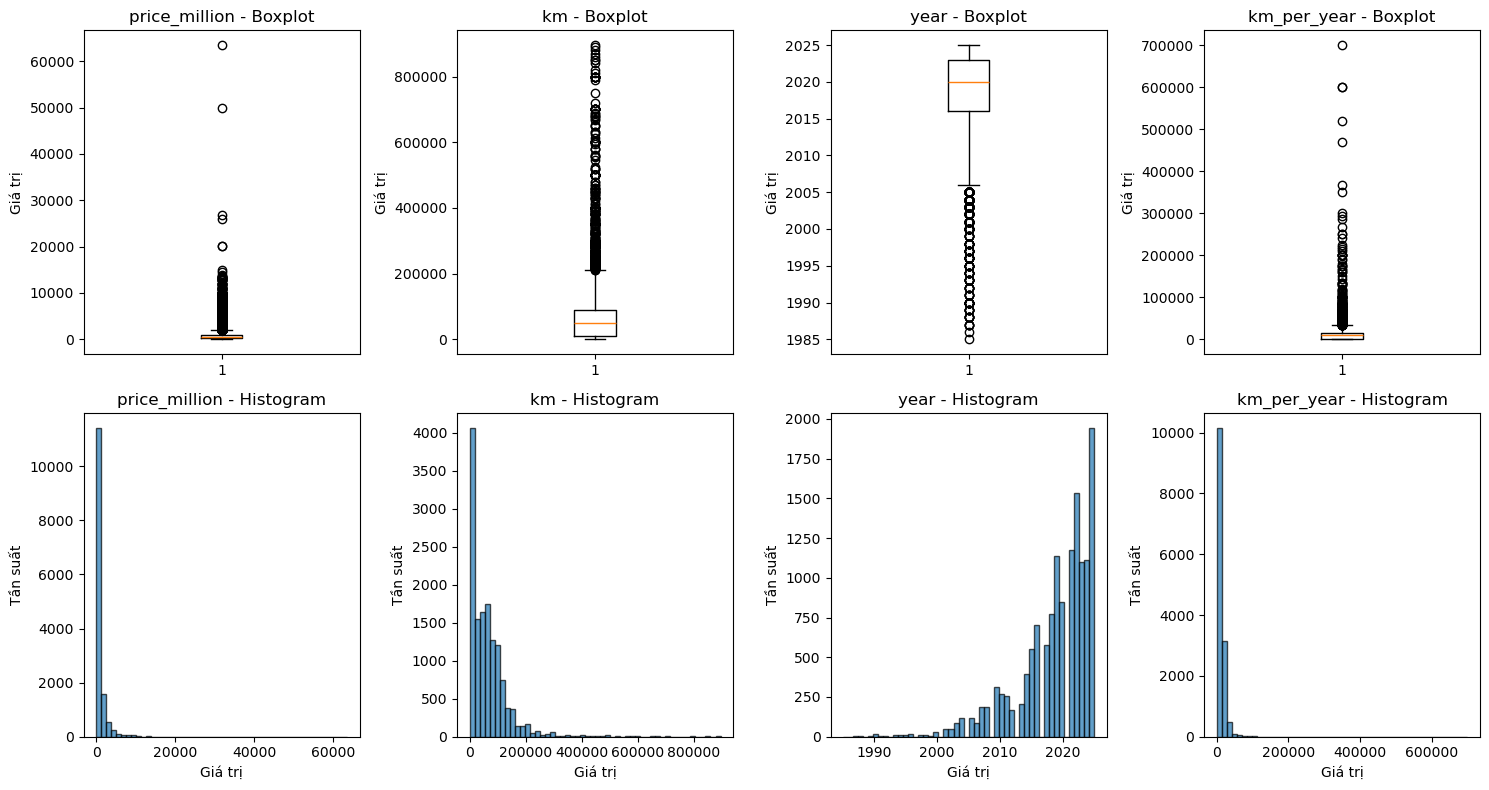

In [537]:
fig, axes = plt.subplots(2, 4, figsize=(15, 8))

for i, col in enumerate(numeric_cols):
    # Boxplot
    axes[0, i].boxplot(df[col].dropna())
    axes[0, i].set_title(f'{col} - Boxplot')
    axes[0, i].set_ylabel('Giá trị')
    
    # Histogram
    axes[1, i].hist(df[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
    axes[1, i].set_title(f'{col} - Histogram')
    axes[1, i].set_xlabel('Giá trị')
    axes[1, i].set_ylabel('Tần suất')

plt.tight_layout()
plt.show()

**Nhận xét từ biểu đồ:**

| Biến | Boxplot | Histogram | Nhận xét |
|------|---------|-----------|----------|
| `price_million` | Nhiều outliers phía trên, giá trị max ~60,000 triệu | Phân phối lệch phải mạnh, tập trung ở mức thấp | Có xe siêu sang giá rất cao + một số lỗi nhập liệu |
| `km` | Outliers rõ rệt > 500k km, max ~2 triệu km | Phân phối lệch phải, đa số xe < 100k km | Các giá trị > 500k km có thể là lỗi |
| `year` | Outliers ở các năm cũ (1985-1995) | Đa số xe từ 2015-2025, ít xe trước 2005 | Dữ liệu tập trung vào xe đời mới, xe quá cũ cần xem xét loại bỏ |
| `km_per_year` | Hầu hết các gía trị nằm ở dưới 100,000 có các outliner vô lý rõ ràng (700,000km/năm) | Phân phối lệch phải | Nhiều xe bị lỗi nhập liệu/ người bán muốn để số km là số đẹp,.. |

→ Cần loại bỏ các outliers rõ ràng là lỗi nhập liệu, nhưng giữ lại các xe cao cấp có giá hợp lý.

#### 3.2 Xác định ngưỡng outliers bằng IQR

Phương pháp IQR (Interquartile Range):
- Q1 = phân vị 25%, Q3 = phân vị 75%
- IQR = Q3 - Q1
- Lower bound = Q1 - 1.5 × IQR
- Upper bound = Q3 + 1.5 × IQR

Tuy nhiên, với dữ liệu giá xe có phân phối lệch, ta sẽ kết hợp IQR với domain knowledge.

In [538]:
def get_iqr_bounds(series):
    """Tính ngưỡng outliers bằng IQR"""
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return lower, upper

# Tính IQR bounds cho từng biến
for col in numeric_cols:
    lower, upper = get_iqr_bounds(df[col].dropna())
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"{col}:")
    print(f"  IQR bounds: [{lower:.2f}, {upper:.2f}]")
    print(f"  Số outliers (IQR): {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")
    print()

price_million:
  IQR bounds: [-598.50, 1957.50]
  Số outliers (IQR): 1624 (11.53%)

km:
  IQR bounds: [-110000.00, 210000.00]
  Số outliers (IQR): 437 (3.10%)

year:
  IQR bounds: [2005.50, 2033.50]
  Số outliers (IQR): 560 (3.98%)

km_per_year:
  IQR bounds: [-18150.00, 34250.00]
  Số outliers (IQR): 396 (2.81%)



#### 3.3 Xác định ngưỡng thực tế (Domain Knowledge)

IQR có thể quá nghiêm ngặt với dữ liệu giá xe (phát hiện 11.86% outliers cho price). Ta kết hợp kiến thức thực tế về thị trường xe Việt Nam:

| Biến | IQR outliers | Ngưỡng thấp | Ngưỡng cao | Outliers thực tế | Lý do |
|------|--------------|-------------|------------|------------------|-------|
| `price_million` | 11.86% | 50 | 15,000 | 1.69% | Xe dưới 50 triệu ít tin cậy, trên 15 tỷ là siêu xe hiếm |
| `km` | 2.97% | 0 | 500,000 | 0.48% | Xe trên 500k km rất hiếm, có thể là lỗi |
| `year` | 2.19% | 1995 | 2025 | 0.40% | Xe quá cũ (trước 1995) không có giá trị tham khảo |
| `km_per_year` | 2.45% | 0 | 100000 | 0.34% | Các xe chạy dịch vụ có thể chạy tới 200-300km/ ngày. Vì đây là xe hơi chứ không phải xe tải nên không có các chuyến Bắc-Nam liên tục => Các gía trị cao hơn là bất khả thi|

In [539]:
# Định nghĩa ngưỡng phát hiện ban đầu (để khảo sát)
OUTLIER_BOUNDS_DETECT = {
    'price_million': (50, 15000),     # 50 triệu - 15 tỷ 
    'km': (0, 500000),                # 0 - 500k km
    'year': (1995, 2025),             # 1995 - 2025
    'km_per_year': (0, 100000)        # 0 - 100k km/năm
}

# Đếm outliers theo ngưỡng phát hiện
print("Số lượng outliers theo ngưỡng phát hiện:\n")

for col, (lower, upper) in OUTLIER_BOUNDS_DETECT.items():
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"{col} [{lower}, {upper}]: {len(outliers)} outliers ({len(outliers)/len(df)*100:.2f}%)")
    
    # Chi tiết theo source
    for source in ['chotot', 'bonbanh']:
        source_outliers = outliers[outliers['source'] == source]
        print(f"  - {source}: {len(source_outliers)} outliers")

Số lượng outliers theo ngưỡng phát hiện:

price_million [50, 15000]: 251 outliers (1.78%)
  - chotot: 243 outliers
  - bonbanh: 8 outliers
km [0, 500000]: 66 outliers (0.47%)
  - chotot: 59 outliers
  - bonbanh: 7 outliers
year [1995, 2025]: 60 outliers (0.43%)
  - chotot: 57 outliers
  - bonbanh: 3 outliers
km_per_year [0, 100000]: 50 outliers (0.36%)
  - chotot: 44 outliers
  - bonbanh: 6 outliers


#### 3.4 Xem xét các outliers

Trước khi loại bỏ, cần xem xét các giá trị outliers để đảm bảo không loại nhầm dữ liệu hợp lệ.

In [540]:
# Xem các xe có giá quá thấp (< 50 triệu)
low_price = df[df['price_million'] < 50][['brand', 'model', 'year', 'price_million', 'source']]
print(f"Xe có giá < 50 triệu: {len(low_price)} xe")
if len(low_price) > 0:
    print(low_price.head(10))

Xe có giá < 50 triệu: 245 xe
       brand      model    year  price_million  source
48   Hyundai  Grand i10  2017.0            8.0  chotot
74    Toyota      Camry  1987.0           39.0  chotot
93    Daewoo      Matiz  2007.0            5.5  chotot
95    Daewoo      Lanos  2003.0           25.0  chotot
103      Kia     Cerato  2018.0            5.0  chotot
125    Honda       City  2019.0           40.0  chotot
137     Ford    Transit  2004.0           42.0  chotot
150  Hyundai  Stargazer  2024.0            5.0  chotot
180  VinFast        VF3  2025.0           46.0  chotot
203     Fiat      Siena  2002.0           45.0  chotot


Các xe dưới 50 triệu hầu hết là xe cỏ/ xe rất cũ/ hỏng hóc,.. chúng ta sẽ lược bỏ toàn bộ

In [541]:
# Xem các xe có giá quá cao (> 15 tỷ)
high_price = df[df['price_million'] > 15000][['brand', 'model', 'year', 'price_million', 'source']]
print(f"Xe có giá > 15 tỷ: {len(high_price)} xe")
if len(high_price) > 0:
    print(high_price)

Xe có giá > 15 tỷ: 6 xe
             brand                 model    year  price_million   source
3612         Acura                   ILX  2021.0        50000.0   chotot
9118   Rolls Royce           Phantom EWB  2022.0        63500.0  bonbanh
9590     LandRover    Range Rover SV SWB  2025.0        20200.0  bonbanh
10201  Rolls Royce  Cullinan Black Badge  2020.0        26900.0  bonbanh
11129    LandRover    Range Rover SV SWB  2025.0        20165.0  bonbanh
14611  Rolls Royce              Cullinan  2024.0        25900.0  bonbanh


Số xe có giá >15 tỷ chỉ có 6 xe, sau khi kiểm tra thủ công thì chỉ có 1 trường hợp thực sự cần loại bỏ là `Acura ILX`.

In [542]:
# Xem các xe có km quá cao (> 500k)
high_km = df[df['km'] > 500000][['brand', 'model', 'year', 'km', 'source']]
print(f"Xe có km > 500,000: {len(high_km)} xe")
if len(high_km) > 0:
    print(high_km)

Xe có km > 500,000: 66 xe
               brand           model    year        km   source
134              Kia         Morning  2008.0  600000.0   chotot
321          Hyundai        Santa Fe  2020.0  841000.0   chotot
510          Hyundai       Grand i10  2021.0  700000.0   chotot
529    Mercedes Benz        Sprinter  2005.0  888888.0   chotot
645           Toyota            Zace  2003.0  850000.0   chotot
...              ...             ...     ...       ...      ...
9034         VinFast  Lux SA Premium  2019.0  790000.0  bonbanh
11079        VinFast     Lux SA Plus  2021.0  750000.0  bonbanh
12623          Honda           CRV L  2019.0  600000.0  bonbanh
13144          Honda           CRV L  2019.0  580000.0  bonbanh
14115         Toyota       Vios 1.5G  2016.0  820000.0  bonbanh

[66 rows x 5 columns]


Hầu hết các xe có odo >500,000km là dó lỗi nhập liệu hoặc người bán muốn nhập số đẹp (vd: 666666, 989898,..). Có thể loại bỏ toàn bộ

#### 3.4a Xem xét outliers dựa trên km_per_year

Kiểm tra các xe có mức sử dụng bất thường (km_per_year quá cao)

In [543]:
EXTREME_KM_PER_YEAR = 100000  # 100,000 km/năm

extreme_usage = df[df['km_per_year'] > EXTREME_KM_PER_YEAR].copy()

print(f"Số xe có km_per_year > {EXTREME_KM_PER_YEAR:,.0f}: {len(extreme_usage)}")

if len(extreme_usage) > 0:
    print(f"\nTop 10 xe có km_per_year cao nhất:")
    extreme_usage_sorted = extreme_usage.sort_values('km_per_year', ascending=False)
    print(extreme_usage_sorted[['brand', 'model', 'year', 'age', 'km', 'km_per_year']].head(10))
    
    # Thống kê
    print(f"\nThống kê các xe bất thường:")
    print(f"  km_per_year range: {extreme_usage['km_per_year'].min():,.0f} - {extreme_usage['km_per_year'].max():,.0f}")
    print(f"  km/day equivalent: {extreme_usage['km_per_year'].min()/365:.0f} - {extreme_usage['km_per_year'].max()/365:.0f}")
else:
    print("Không có xe nào vượt ngưỡng extreme usage.")

Số xe có km_per_year > 100,000: 50

Top 10 xe có km_per_year cao nhất:
           brand          model    year  age        km    km_per_year
3192  Mitsubishi        Xpander  2024.0  1.0  700000.0  700000.000000
1147      Suzuki           XL 7  2024.0  1.0  600000.0  600000.000000
2074  Mitsubishi  Xpander Cross  2024.0  1.0  600000.0  600000.000000
4619     Hyundai      Stargazer  2024.0  1.0  520000.0  520000.000000
2730  Mitsubishi        Xpander  2024.0  1.0  470000.0  470000.000000
1754      Daewoo         Nubira  2024.0  1.0  366000.0  366000.000000
1269       Honda           City  2023.0  2.0  700000.0  350000.000000
900         Ford        Transit  2023.0  2.0  600000.0  300000.000000
3872         Kia             K5  2022.0  3.0  880000.0  293333.333333
732         Ford         Ranger  2022.0  3.0  860000.0  286666.666667

Thống kê các xe bất thường:
  km_per_year range: 104,167 - 700,000
  km/day equivalent: 285 - 1918


#### 3.5 Loại bỏ outliers

Áp dụng ngưỡng thực tế để loại bỏ các giá trị bất thường. Dùng `filter` để loại bỏ hoàn toàn các rows.

**Kết quả kiểm tra thủ công (từ 3.4):**
- Xe giá < 50 triệu: loại bỏ toàn bộ (xe cỏ/hỏng)
- Xe giá > 15 tỷ: chỉ loại 1 xe lỗi nhập liệu (Acura ILX 50,000 tỷ), giữ lại xe siêu sang hợp lệ
- Xe km > 500k: loại bỏ toàn bộ (lỗi nhập liệu)
- Xe km_per_year > 100k: loại bỏ các xe có mức sử dụng bất thường (50 xe có km_per_year > 100k)

In [544]:
def remove_outliers(df, bounds_dict, manual_remove=None):
    """Loại bỏ outliers theo ngưỡng và điều kiện thủ công."""
    df_clean = df.copy()
    initial_len = len(df_clean)
    
    for col, (lower, upper) in bounds_dict.items():
        if col in df_clean.columns:
            if upper is None:
                mask = (df_clean[col] >= lower) | df_clean[col].isna()
                bound_str = f">= {lower}"
            else:
                mask = (df_clean[col] >= lower) & (df_clean[col] <= upper) | df_clean[col].isna()
                bound_str = f"[{lower}, {upper}]"
            removed = len(df_clean) - mask.sum()
            df_clean = df_clean[mask]
            print(f"  {col}: loại bỏ {removed} rows ngoài {bound_str}")
    
    # Loại bỏ thủ công các xe có giá bất thường
    if manual_remove:
        for item in manual_remove:
            before = len(df_clean)
            mask = True
            for key, value in item.items():
                mask = mask & (df_clean[key] == value)
            df_clean = df_clean[~mask]
            removed = before - len(df_clean)
            if removed > 0:
                print(f"  Loại bỏ thủ công: {item} ({removed} rows)")
    
    print(f"  Tổng: {initial_len} -> {len(df_clean)} rows ({initial_len - len(df_clean)} removed)")
    return df_clean

# Ngưỡng thực tế (sau khi kiểm tra 3.4)
OUTLIER_BOUNDS = {
    'price_million': (50, None),      # >= 50 triệu (không giới hạn trên - giữ xe siêu sang)
    'km': (0, 500000),                # 0 - 500k km
    'year': (1995, 2025),             # 1995 - 2025
    'km_per_year': (0, 100000),       # 0 - 100,000 km/năm (~275 km/ngày liên tục)
}

# 2 xe có giá bất thường cần loại bỏ riêng (đã kiểm tra thủ công ở 3.4)
MANUAL_REMOVE = [
    {'brand': 'Acura', 'model': 'ILX', 'price_million': 50000.0},    # Lỗi nhập liệu
]

print(f"Trước khi xử lý: {len(df)} rows")
df = remove_outliers(df, OUTLIER_BOUNDS, MANUAL_REMOVE)
print(f"\nSau khi xử lý: {len(df)} rows")
print(f"  - Chotot: {len(df[df['source'] == 'chotot'])} rows")
print(f"  - BonBanh: {len(df[df['source'] == 'bonbanh'])} rows")

Trước khi xử lý: 14084 rows
  price_million: loại bỏ 245 rows ngoài >= 50
  km: loại bỏ 61 rows ngoài [0, 500000]
  year: loại bỏ 31 rows ngoài [1995, 2025]
  km_per_year: loại bỏ 23 rows ngoài [0, 100000]
  Loại bỏ thủ công: {'brand': 'Acura', 'model': 'ILX', 'price_million': 50000.0} (1 rows)
  Tổng: 14084 -> 13723 rows (361 removed)

Sau khi xử lý: 13723 rows
  - Chotot: 4529 rows
  - BonBanh: 9194 rows


#### 3.6 Kiểm tra kết quả sau khi loại bỏ outliers

So sánh phân phối trước và sau khi xử lý để đảm bảo dữ liệu vẫn hợp lý.

In [545]:
for col in numeric_cols:
    print(f"{col}:")
    print(f"  mean = {df[col].mean():.2f}")
    print(f"  std  = {df[col].std():.2f}")
    print(f"  min  = {df[col].min():.2f}")
    print(f"  max  = {df[col].max():.2f}")
    print()

price_million:
  mean = 1039.38
  std  = 1548.87
  min  = 50.00
  max  = 63500.00

km:
  mean = 60002.89
  std  = 61489.21
  min  = 0.00
  max  = 500000.00

year:
  mean = 2019.00
  std  = 5.44
  min  = 1995.00
  max  = 2025.00

km_per_year:
  mean = 10371.96
  std  = 9993.00
  min  = 0.00
  max  = 100000.00



Visualize phân phối sau khi loại bỏ outliers

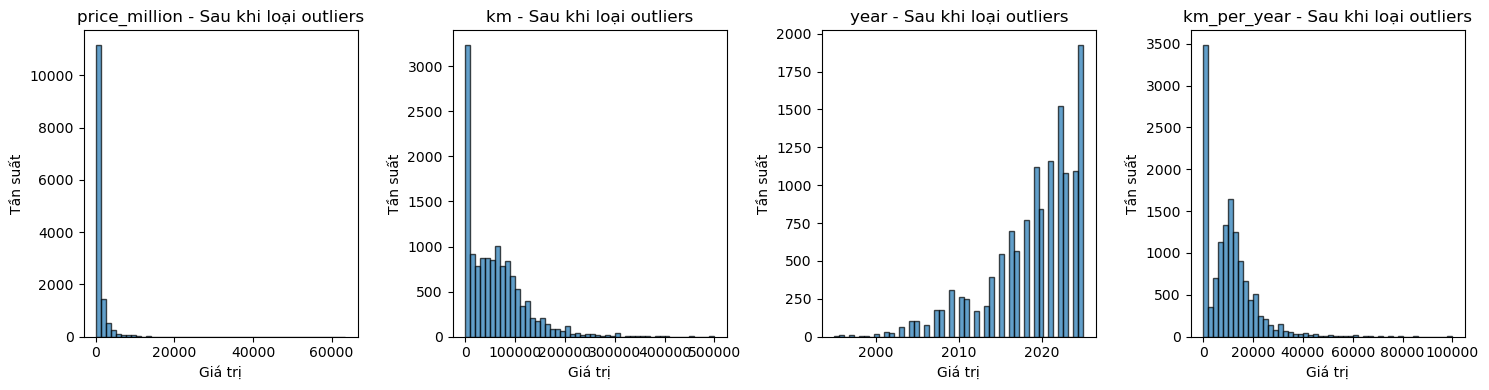

In [546]:
fig, axes = plt.subplots(1, 4, figsize=(15, 4))

for i, col in enumerate(numeric_cols):
    axes[i].hist(df[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
    axes[i].set_title(f'{col} - Sau khi loại outliers')
    axes[i].set_xlabel('Giá trị')
    axes[i].set_ylabel('Tần suất')

plt.tight_layout()
plt.show()

#### 3.7 Tổng kết Phase III

Cập nhật dataframes gốc với phiên bản đã loại bỏ outliers.

In [547]:
df.reset_index(drop=True, inplace=True)

print(f"Kích thước cuối cùng: {len(df)} rows")
print(f"  - Chotot: {len(df[df['source'] == 'chotot'])} rows")
print(f"  - BonBanh: {len(df[df['source'] == 'bonbanh'])} rows")
print(f"\nCác cột: {list(df.columns)}")

Kích thước cuối cùng: 13723 rows
  - Chotot: 4529 rows
  - BonBanh: 9194 rows

Các cột: ['price_million', 'km', 'year', 'brand', 'model', 'transmission', 'fuel_type', 'body_type', 'origin', 'condition', 'seats', 'city', 'engine', 'engine_missing', 'seller_id', 'source', 'age', 'km_per_year']


### IV. Xử lý Missing Values

Sau khi merge và loại bỏ outliers, tiến hành xử lý missing values trên merged dataset.

#### 4.1 Đánh giá Missing Values hiện tại

In [548]:
missing_stats = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df) * 100).round(2)

missing_df = pd.DataFrame({
    'Missing': missing_stats,
    'Percent': missing_pct
}).sort_values('Missing', ascending=False)

print(missing_df[missing_df['Missing'] > 0])
print(f"\nTổng rows: {len(df)}")

              Missing  Percent
origin            970     7.07
body_type         852     6.21
seats             833     6.07
km                229     1.67
km_per_year        62     0.45
transmission       16     0.12
year                6     0.04
age                 6     0.04

Tổng rows: 13723


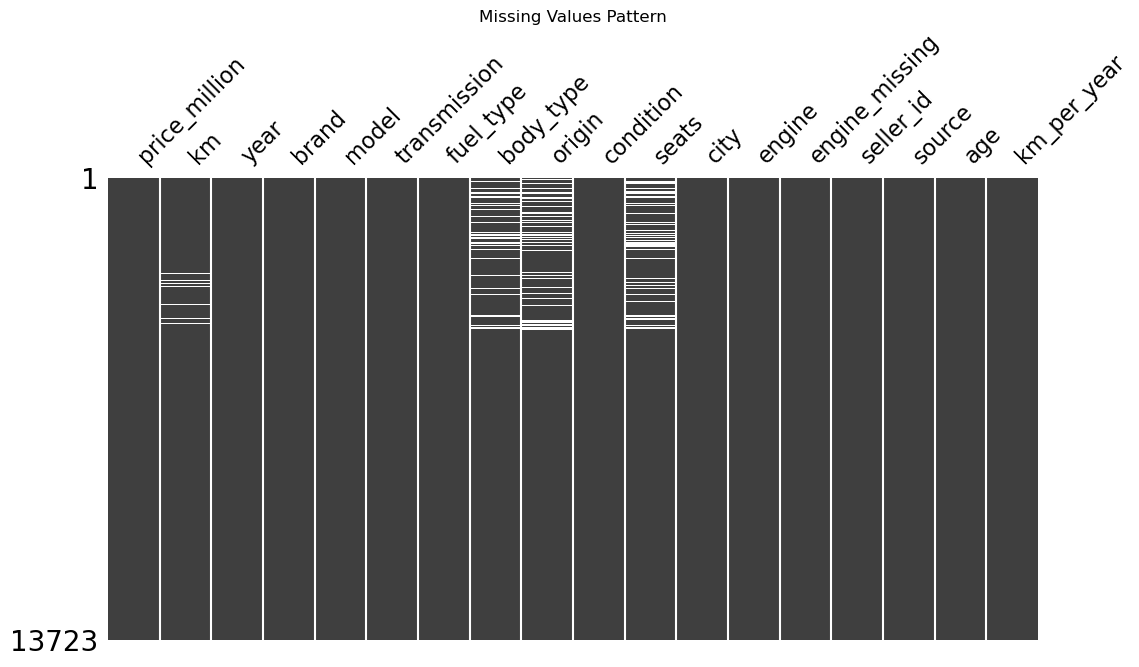

In [549]:
# Visualize missing pattern
msno.matrix(df, figsize=(12, 6), sparkline=False)
plt.title('Missing Values Pattern')
plt.show()

#### 4.2 Chiến lược xử lý Missing Values

| Cột          | Missing | %    | Chiến lược                 | Nguồn dữ liệu                                                                                                                                                 |
|--------------|---------|------|----------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------|
| origin       | 983     | 6.77 | Lookup từ brand            | Các hãng có nhà máy lắp ráp tại VN: Toyota, Honda, Mazda, Ford, Hyundai, Kia, Mitsubishi, Suzuki, Isuzu, Thaco, VinFast → "Trong nước", còn lại → "Nhập khẩu" |
| seats        | 840     | 5.78 | Lookup từ body_type        | Bảng quy ước: SUV/MPV/Van → 7 chỗ, Sedan/Hatchback/Crossover → 5 chỗ, Coupe/Convertible → 4 chỗ                                                               |
| body_type    | 857     | 5.90 | Mode theo model            | Tính từ dữ liệu: mỗi model thường chỉ có 1 kiểu thân xe phổ biến nhất                                                                                         |
| km           | 228     | 1.57 | Theo condition             | Xe "Mới" → 0 km, xe "Cũ" → median theo (brand, model, year)                                                                                                   |
| transmission | 16      | 0.11 | Mode theo (brand, model)   | Tính từ dữ liệu: fallback = AT (phổ biến hơn)                                                                                                                 |
| year         | 6       | 0.04 | Median theo (brand, model) | Tính từ dữ liệu: chỉ 6 dòng, dùng median là đủ                                                                                                                |

#### 4.3 Imputation Functions

In [550]:
def impute_by_mode(df, col, group_cols, fallback=None):
    """
    Điền giá trị missing bằng mode của group.
    Trả về DataFrame đã được cập nhật.
    """
    df = df.copy()
    missing_before = df[col].isna().sum()
    
    # Tính mode theo group
    mode_lookup = df.groupby(group_cols)[col].agg(
        lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else None
    )
    
    # Tạo dict để lookup nhanh hơn
    mode_dict = mode_lookup.to_dict()
    
    def get_mode(row):
        if pd.isna(row[col]):
            if len(group_cols) > 1:
                key = tuple(row[g] for g in group_cols)
            else:
                key = row[group_cols[0]]
            return mode_dict.get(key, fallback)
        return row[col]
    
    df[col] = df.apply(get_mode, axis=1)
    
    # Fill phần còn lại bằng fallback
    if fallback is not None:
        df[col] = df[col].fillna(fallback)
    
    missing_after = df[col].isna().sum()
    print(f"  {col}: {missing_before} -> {missing_after} missing (đã điền {missing_before - missing_after})")
    
    return df


def impute_by_lookup(df, col, lookup_col, lookup_dict, fallback=None):
    """
    Điền giá trị missing bằng lookup table.
    Trả về DataFrame đã được cập nhật.
    """
    df = df.copy()
    missing_before = df[col].isna().sum()
    
    def get_value(row):
        if pd.isna(row[col]):
            return lookup_dict.get(row[lookup_col], fallback)
        return row[col]
    
    df[col] = df.apply(get_value, axis=1)
    
    if fallback is not None:
        df[col] = df[col].fillna(fallback)
    
    missing_after = df[col].isna().sum()
    print(f"  {col}: {missing_before} -> {missing_after} missing (đã điền {missing_before - missing_after})")
    
    return df


def impute_numeric_by_group(df, col, group_cols, method='median', fallback=None):
    """
    Điền giá trị missing cho cột numeric bằng median/mean của group.
    """
    df = df.copy()
    missing_before = df[col].isna().sum()
    
    # Tính median/mean theo group
    if method == 'median':
        group_stats = df.groupby(group_cols)[col].median()
    else:
        group_stats = df.groupby(group_cols)[col].mean()
    
    group_dict = group_stats.to_dict()
    
    def get_value(row):
        if pd.isna(row[col]):
            if len(group_cols) > 1:
                key = tuple(row[g] for g in group_cols)
            else:
                key = row[group_cols[0]]
            val = group_dict.get(key)
            return val if pd.notna(val) else fallback
        return row[col]
    
    df[col] = df.apply(get_value, axis=1)
    
    if fallback is not None:
        df[col] = df[col].fillna(fallback)
    
    missing_after = df[col].isna().sum()
    print(f"  {col}: {missing_before} -> {missing_after} missing (đã điền {missing_before - missing_after})")
    
    return df

#### 4.4a Impute body_type (mode theo model)

In [551]:
sample_missing = df[df['body_type'].isna()][['brand', 'model', 'body_type']].head(10)
df = impute_by_mode(df, 'body_type', ['model'], fallback='Kiểu dáng khác')
print("\nSample dữ liệu SAU khi impute:")
df.loc[sample_missing.index, ['brand', 'model', 'body_type']]

  body_type: 852 -> 0 missing (đã điền 852)

Sample dữ liệu SAU khi impute:


,brand,model,body_type
3,Daewoo,Gentra,Sedan
5,Toyota,Camry,Sedan
7,VinFast,VFe34,SUV / Cross over
13,Toyota,Innova,Minivan (MPV)
16,Suzuki,Ertiga,SUV / Cross over
23,Honda,Civic,Sedan
30,Ford,Transit,Van
31,Kia,Sonet,SUV / Cross over
35,VinFast,VF3,SUV / Cross over
51,Kia,Sorento,SUV / Cross over


#### 4.4b Impute seats (lookup từ body_type)

In [552]:
# Định nghĩa bảng lookup seats theo body_type
# Nguồn: quy ước phổ biến trong ngành ô tô Việt Nam
SEATS_LOOKUP = {
    'SUV': 7,              # SUV thường 7 chỗ
    'SUV / Cross over': 7, # SUV/Crossover từ BonBanh
    'Crossover': 5,        # Crossover nhỏ hơn: 5 chỗ
    'Sedan': 5,            # Sedan: 5 chỗ
    'Hatchback': 5,        # Hatchback: 5 chỗ
    'MPV': 7,              # Multi-Purpose Vehicle: 7 chỗ
    'Pickup': 5,           # Bán tải: 5 chỗ
    'Coupe': 4,            # Coupe: 4 chỗ
    'Convertible': 4,      # Mui trần: 4 chỗ
    'Van': 7,              # Van: 7+ chỗ
    'Wagon': 5,            # Wagon: 5 chỗ
    'Minivan': 7,          # Minivan: 7 chỗ
    'Kiểu dáng khác': 5,   # Mặc định: 5 chỗ
    'unknown': 5,          # Mặc định: 5 chỗ
}

In [553]:
sample_missing = df[df['seats'].isna()][['brand', 'model', 'body_type', 'seats']].head(10)
df = impute_by_lookup(df, 'seats', 'body_type', SEATS_LOOKUP, fallback=5)
print("\nSample dữ liệu SAU khi impute (cùng index):")
df.loc[sample_missing.index, ['brand', 'model', 'body_type', 'seats']]

  seats: 833 -> 0 missing (đã điền 833)

Sample dữ liệu SAU khi impute (cùng index):


,brand,model,body_type,seats
3,Daewoo,Gentra,Sedan,5.0
5,Toyota,Camry,Sedan,5.0
13,Toyota,Innova,Minivan (MPV),5.0
16,Suzuki,Ertiga,SUV / Cross over,7.0
18,BMW,3 Series,Sedan,5.0
27,Honda,Civic,Sedan,5.0
30,Ford,Transit,Van,7.0
34,Mitsubishi,Triton,Pick-up (bán tải),5.0
41,Nissan,Sunny,Sedan,5.0
50,MG,MG5,Sedan,5.0


#### 4.4c Impute transmission (mode theo brand, model)

In [554]:
sample_missing = df[df['transmission'].isna()][['brand', 'model', 'transmission']].head(10)
df = impute_by_mode(df, 'transmission', ['brand', 'model'], fallback='AT')
print("\nSample dữ liệu SAU khi impute:")
df.loc[sample_missing.index, ['brand', 'model', 'transmission']]

  transmission: 16 -> 0 missing (đã điền 16)

Sample dữ liệu SAU khi impute:


,brand,model,transmission
199,Toyota,Corolla Cross,AT
1212,Mitsubishi,Attrage,MT
1427,Mitsubishi,Attrage,MT
1516,Mitsubishi,Outlander,AT
2000,Mitsubishi,Outlander,AT
2036,Honda,CR V,AT
2047,Toyota,Corolla Cross,AT
2435,Kia,Seltos,AT
2511,Mitsubishi,Outlander,AT
3411,Honda,CR V,AT


#### 4.4d Impute origin (lookup từ brand)

In [555]:
# Định nghĩa danh sách các hãng có nhà máy lắp ráp/sản xuất tại Việt Nam
# Nguồn: thông tin từ các nhà máy ô tô tại VN (Toyota VN, Honda VN, Ford VN, etc.)
VN_BRANDS = [
    'Toyota',      
    'Honda',       
    'Mazda',       
    'Ford',        
    'Hyundai',     
    'Kia',         
    'Mitsubishi', 
    'Suzuki',      
    'Isuzu',       
    'Thaco',       
    'VinFast',     
]

# Tạo lookup dict: hãng VN -> "Trong nước", còn lại -> "Nhập khẩu"
ORIGIN_LOOKUP = {brand: 'Trong nước' for brand in VN_BRANDS}

In [556]:
sample_missing = df[df['origin'].isna()][['brand', 'model', 'origin']].head(10)
df = impute_by_lookup(df, 'origin', 'brand', ORIGIN_LOOKUP, fallback='Nhập khẩu')
print("\nSample dữ liệu SAU khi impute:")
df.loc[sample_missing.index, ['brand', 'model', 'origin']]

  origin: 970 -> 0 missing (đã điền 970)

Sample dữ liệu SAU khi impute:


,brand,model,origin
5,Toyota,Camry,Trong nước
7,VinFast,VFe34,Trong nước
15,Chevrolet,Cruze,Nhập khẩu
22,Hyundai,Grand i10,Trong nước
23,Honda,Civic,Trong nước
24,Porsche,Cayenne,Nhập khẩu
29,BMW,X5,Nhập khẩu
30,Ford,Transit,Trong nước
35,VinFast,VF3,Trong nước
44,Mazda,3,Trong nước


#### 4.4e Impute km (theo condition)

In [557]:
sample_missing = df[df['km'].isna()][['brand', 'model', 'year', 'condition', 'km']].head(10)
# Chiến lược:
# - Xe "Mới" -> km = 0 (xe mới chưa chạy)
# - Xe "Cũ" -> median theo (brand, model, year)

km_missing_before = df['km'].isna().sum()

# Fill xe mới với km = 0
new_car_mask = (df['km'].isna()) & (df['condition'] == 'Mới')
df.loc[new_car_mask, 'km'] = 0
new_filled = new_car_mask.sum()

# Fill xe cũ với median theo (brand, model, year)
overall_km_median = df['km'].median()
km_by_group = df.groupby(['brand', 'model', 'year'])['km'].median().to_dict()

def get_km(row):
    if pd.isna(row['km']):
        key = (row['brand'], row['model'], row['year'])
        val = km_by_group.get(key)
        return val if pd.notna(val) else overall_km_median
    return row['km']

old_car_missing = df['km'].isna().sum()
df['km'] = df.apply(get_km, axis=1)
old_filled = old_car_missing - df['km'].isna().sum()

km_missing_after = df['km'].isna().sum()

print("Sample dữ liệu SAU khi impute (cùng index):")
df.loc[sample_missing.index, ['brand', 'model', 'year', 'condition', 'km']]

Sample dữ liệu SAU khi impute (cùng index):


,brand,model,year,condition,km
12,VinFast,Limo Green,2025.0,Mới,0.0
25,Mitsubishi,Xpander,2025.0,Mới,0.0
39,Mitsubishi,Xpander,2025.0,Mới,0.0
43,Mitsubishi,Xforce,2025.0,Mới,0.0
73,Chery,Jaecoo 7,2025.0,Mới,0.0
92,MG,HS,2024.0,Mới,0.0
93,Lynk&Co,06,2025.0,Mới,0.0
159,VinFast,VF3,2025.0,Mới,0.0
233,Hyundai,Elantra,2017.0,Cũ,90000.0
292,VinFast,VF3,2024.0,Mới,0.0


#### 4.4f Impute year (median theo brand, model)

In [558]:
sample_missing = df[df['year'].isna()][['brand', 'model', 'year']].head(10)

year_missing_before = df['year'].isna().sum()
overall_year_median = df['year'].median()
year_by_brand_model = df.groupby(['brand', 'model'])['year'].median().to_dict()

def get_year(row):
    if pd.isna(row['year']):
        key = (row['brand'], row['model'])
        val = year_by_brand_model.get(key)
        return val if pd.notna(val) else overall_year_median
    return row['year']

df['year'] = df.apply(get_year, axis=1)
year_missing_after = df['year'].isna().sum()

print("\nSample dữ liệu SAU khi impute:")
df.loc[sample_missing.index, ['brand', 'model', 'year']]


Sample dữ liệu SAU khi impute:


,brand,model,year
1094,Jeep,Dòng khác,2020.0
2030,Jeep,CJ,2020.0
2379,Hãng khác,Dòng khác,2022.0
5086,Toyota,Land Cruiser BJ70,2020.0
5326,Toyota,Publica 800 Convertible,2020.0
8321,Jeep,Khác 1.3MT,2020.0


#### 4.5 Validation sau Imputation

In [559]:
missing_after = df.isnull().sum()
cols_with_missing = missing_after[missing_after > 0]

if len(cols_with_missing) == 0:
    print("OK - Không còn missing values!")
else:
    print("Vẫn còn missing values:")
    print(cols_with_missing)

print(f"\nKích thước dataset: {len(df)} rows x {len(df.columns)} cols")
print(f"\nCác cột: {list(df.columns)}")

Vẫn còn missing values:
age             6
km_per_year    62
dtype: int64

Kích thước dataset: 13723 rows x 18 cols

Các cột: ['price_million', 'km', 'year', 'brand', 'model', 'transmission', 'fuel_type', 'body_type', 'origin', 'condition', 'seats', 'city', 'engine', 'engine_missing', 'seller_id', 'source', 'age', 'km_per_year']


In [560]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13723 entries, 0 to 13722
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price_million   13723 non-null  float64
 1   km              13723 non-null  float64
 2   year            13723 non-null  float64
 3   brand           13723 non-null  object 
 4   model           13723 non-null  object 
 5   transmission    13723 non-null  object 
 6   fuel_type       13723 non-null  object 
 7   body_type       13723 non-null  object 
 8   origin          13723 non-null  object 
 9   condition       13723 non-null  object 
 10  seats           13723 non-null  float64
 11  city            13723 non-null  object 
 12  engine          13723 non-null  float64
 13  engine_missing  13723 non-null  int64  
 14  seller_id       13723 non-null  object 
 15  source          13723 non-null  object 
 16  age             13717 non-null  float64
 17  km_per_year     13661 non-null 

#### 4.6 Tổng kết Phase IV

**Tổng kết Phase IV:**

Dataset sau xử lý missing values: **14,526 rows × 17 cols**

| Cột | Chiến lược | Nguồn dữ liệu |
|-----|------------|---------------|
| body_type | Mode theo model | Tính từ dữ liệu |
| seats | Lookup từ body_type | Bảng SEATS_LOOKUP |
| transmission | Mode theo (brand, model) | Tính từ dữ liệu |
| origin | Lookup từ brand | Danh sách VN_BRANDS |
| km | Xe mới → 0, xe cũ → median | Tính từ dữ liệu |
| year | Median theo (brand, model) | Tính từ dữ liệu |

In [561]:
df.head(10)

,price_million,km,year,brand,model,transmission,fuel_type,body_type,origin,condition,seats,city,engine,engine_missing,seller_id,source,age,km_per_year
0,210.0,200000.0,2020.0,Toyota,Wigo,MT,Xăng,Hatchback,Nhập khẩu,Cũ,5.0,Hồ Chí Minh,0.0,1,bf8ec81ff74b13e68547baef01123083,chotot,5.0,40000.000000
1,295.0,160.0,2017.0,Chevrolet,Colorado,MT,Dầu,Pick-up (bán tải),Nhập khẩu,Cũ,5.0,Hồ Chí Minh,0.0,1,3555f5e4f94d1553395b639630ea6ce1,chotot,8.0,20.000000
2,589.0,14000.0,2024.0,VinFast,VF6,AT,Điện,SUV / Cross over,Trong nước,Cũ,5.0,Hồ Chí Minh,0.0,1,7ed3e52ff9b6ad18a9cdb3f92c2b0e0e,chotot,1.0,14000.000000
3,105.0,130000.0,2010.0,Daewoo,Gentra,MT,Xăng,Sedan,Trong nước,Cũ,5.0,Hồ Chí Minh,0.0,1,fdde5dfa7299cd0d29b7cc2926b42a07,chotot,15.0,8666.666667
4,415.0,120.0,2017.0,Ford,Ranger,AT,Dầu,Pick-up (bán tải),Nhập khẩu,Cũ,5.0,Hồ Chí Minh,0.0,1,4c8bf38251a85124c7a32597682fbca1,chotot,8.0,15.000000
5,125.0,50000.0,2002.0,Toyota,Camry,MT,Xăng,Sedan,Trong nước,Cũ,5.0,Hồ Chí Minh,0.0,1,54603360f9989d5c8a08eb9ac8eaeb1a,chotot,23.0,2173.913043
6,700.0,16850.0,2022.0,Volkswagen,T-Cross,AT,Xăng,SUV / Cross over,Nhập khẩu,Cũ,5.0,Hồ Chí Minh,0.0,1,c7c1ae46e1165992da72ad03742175a3,chotot,3.0,5616.666667
7,440.0,50000.0,2022.0,VinFast,VFe34,AT,Điện,SUV / Cross over,Trong nước,Cũ,5.0,Hồ Chí Minh,0.0,1,70cb05d7a18a7ab67e9fffc2ab2bf760,chotot,3.0,16666.666667
8,579.0,9979.0,2023.0,Mitsubishi,Xpander,AT,Xăng,SUV / Cross over,Nhập khẩu,Cũ,7.0,Hồ Chí Minh,0.0,1,e2c4d3cf25d0bcca8df95e03f702c9e7,chotot,2.0,4989.500000
9,950.0,70000.0,2019.0,Mercedes Benz,C Class,AT,Xăng,Sedan,Trong nước,Cũ,5.0,Hồ Chí Minh,0.0,1,a25e2ec163d1dedd55c8f4f283afac27,chotot,6.0,11666.666667


### V. Feature Engineering

#### 5.1 Tạo features mới

In [562]:
# age: tuổi xe (năm)
CURRENT_YEAR = datetime.now().year

df['age'] = CURRENT_YEAR - df['year']

# km_per_year: số km trung bình mỗi năm
# Xe mới (age=0) → fill = 0
df['km_per_year'] = df.apply(
    lambda row: 0 if row['age'] == 0 else row['km'] / row['age'],
    axis=1
)

# is_luxury: xe sang (1) hay xe phổ thông (0)
LUXURY_BRANDS = [
    'Mercedes Benz', 'BMW', 'Lexus', 'Porsche', 'Jaguar', 'Volvo',
    'Bentley', 'Rolls Royce', 'Maserati', 'Ferrari', 'Lamborghini',
    'Genesis'
]
df['is_luxury'] = df['brand'].isin(LUXURY_BRANDS).astype(int)

df[['brand', 'year', 'age', 'km', 'km_per_year', 'is_luxury']].head(10)

,brand,year,age,km,km_per_year,is_luxury
0,Toyota,2020.0,5.0,200000.0,40000.000000,0
1,Chevrolet,2017.0,8.0,160.0,20.000000,0
2,VinFast,2024.0,1.0,14000.0,14000.000000,0
3,Daewoo,2010.0,15.0,130000.0,8666.666667,0
4,Ford,2017.0,8.0,120.0,15.000000,0
5,Toyota,2002.0,23.0,50000.0,2173.913043,0
6,Volkswagen,2022.0,3.0,16850.0,5616.666667,0
7,VinFast,2022.0,3.0,50000.0,16666.666667,0
8,Mitsubishi,2023.0,2.0,9979.0,4989.500000,0
9,Mercedes Benz,2019.0,6.0,70000.0,11666.666667,1


In [563]:
# Kiểm tra phân bố is_luxury
print(f"Số xe sang: {df['is_luxury'].sum()} ({df['is_luxury'].mean()*100:.1f}%)")
print(f"\nThống kê age và km_per_year:")
df[['age', 'km_per_year']].describe()

Số xe sang: 2622 (19.1%)

Thống kê age và km_per_year:


,age,km_per_year
count,13723.000000,13723.000000
mean,6.002332,10342.493043
std,5.434656,9987.831078
min,0.000000,0.000000
25%,2.000000,1428.571429
50%,5.000000,9571.428571
75%,9.000000,14500.000000
max,30.000000,100000.000000


#### 5.2 Usage Intensity

Phân loại mức độ sử dụng xe dựa trên km_per_year:

In [564]:
# Phân loại mức độ sử dụng xe
def classify_usage(km_per_year):
    if km_per_year < 10000:
        return 'low'
    elif km_per_year <= 20000:
        return 'medium'
    else:
        return 'high'

df['usage'] = df['km_per_year'].apply(classify_usage)

# Kiểm tra phân bố
print("Phân bố usage:")
print(df['usage'].value_counts())
print(f"\nTỷ lệ:")
print(df['usage'].value_counts(normalize=True) * 100)

Phân bố usage:
usage
low       7067
medium    5193
high      1463
Name: count, dtype: int64

Tỷ lệ:
usage
low       51.497486
medium    37.841580
high      10.660934
Name: proportion, dtype: float64


In [565]:
df.head(10)

,price_million,km,year,brand,model,transmission,fuel_type,body_type,origin,condition,seats,city,engine,engine_missing,seller_id,source,age,km_per_year,is_luxury,usage
0,210.0,200000.0,2020.0,Toyota,Wigo,MT,Xăng,Hatchback,Nhập khẩu,Cũ,5.0,Hồ Chí Minh,0.0,1,bf8ec81ff74b13e68547baef01123083,chotot,5.0,40000.000000,0,high
1,295.0,160.0,2017.0,Chevrolet,Colorado,MT,Dầu,Pick-up (bán tải),Nhập khẩu,Cũ,5.0,Hồ Chí Minh,0.0,1,3555f5e4f94d1553395b639630ea6ce1,chotot,8.0,20.000000,0,low
2,589.0,14000.0,2024.0,VinFast,VF6,AT,Điện,SUV / Cross over,Trong nước,Cũ,5.0,Hồ Chí Minh,0.0,1,7ed3e52ff9b6ad18a9cdb3f92c2b0e0e,chotot,1.0,14000.000000,0,medium
3,105.0,130000.0,2010.0,Daewoo,Gentra,MT,Xăng,Sedan,Trong nước,Cũ,5.0,Hồ Chí Minh,0.0,1,fdde5dfa7299cd0d29b7cc2926b42a07,chotot,15.0,8666.666667,0,low
4,415.0,120.0,2017.0,Ford,Ranger,AT,Dầu,Pick-up (bán tải),Nhập khẩu,Cũ,5.0,Hồ Chí Minh,0.0,1,4c8bf38251a85124c7a32597682fbca1,chotot,8.0,15.000000,0,low
5,125.0,50000.0,2002.0,Toyota,Camry,MT,Xăng,Sedan,Trong nước,Cũ,5.0,Hồ Chí Minh,0.0,1,54603360f9989d5c8a08eb9ac8eaeb1a,chotot,23.0,2173.913043,0,low
6,700.0,16850.0,2022.0,Volkswagen,T-Cross,AT,Xăng,SUV / Cross over,Nhập khẩu,Cũ,5.0,Hồ Chí Minh,0.0,1,c7c1ae46e1165992da72ad03742175a3,chotot,3.0,5616.666667,0,low
7,440.0,50000.0,2022.0,VinFast,VFe34,AT,Điện,SUV / Cross over,Trong nước,Cũ,5.0,Hồ Chí Minh,0.0,1,70cb05d7a18a7ab67e9fffc2ab2bf760,chotot,3.0,16666.666667,0,medium
8,579.0,9979.0,2023.0,Mitsubishi,Xpander,AT,Xăng,SUV / Cross over,Nhập khẩu,Cũ,7.0,Hồ Chí Minh,0.0,1,e2c4d3cf25d0bcca8df95e03f702c9e7,chotot,2.0,4989.500000,0,low
9,950.0,70000.0,2019.0,Mercedes Benz,C Class,AT,Xăng,Sedan,Trong nước,Cũ,5.0,Hồ Chí Minh,0.0,1,a25e2ec163d1dedd55c8f4f283afac27,chotot,6.0,11666.666667,1,medium


#### 5.3 Lưu dữ liệu trước khi encoding

In [566]:
df.to_csv('../datasets/non_encoded_car_features.csv', index=False)
print(f"Đã lưu dataset: ../datasets/non_encoded_car_features.csv")
print(f"Kích thước: {df.shape[0]} rows x {df.shape[1]} cols")

Đã lưu dataset: ../datasets/non_encoded_car_features.csv
Kích thước: 13723 rows x 20 cols


### VI. Encoding

#### Tổng quan

In [567]:
# Xem số lượng unique values của các cột categorical
cat_cols = ['brand', 'model', 'transmission', 'fuel_type', 'body_type', 'origin', 'condition', 'city', 'source', 'usage']
for col in cat_cols:
    print(f"{col}: {df[col].nunique()} unique values")

brand: 84 unique values
model: 1400 unique values
transmission: 2 unique values
fuel_type: 4 unique values
body_type: 17 unique values
origin: 2 unique values
condition: 2 unique values
city: 60 unique values
source: 2 unique values
usage: 3 unique values


**Chiến lược encoding:**
- **Binary Encoding:** `transmission` (2 values), `origin` (2 values), `condition` (2 values), `source` (2 values)
- **One-hot Encoding:** `usage` (3 values) `fuel_type` (4 values), `body_type` (17 values after grouping)
- **Group + One-hot:** `brand` (85 → group thành ~20), `city` (60 → group thành ~15)
- **Target Encoding:** `model` (1400 values - quá nhiều cho one-hot)

#### 6.1 One-hot Encoding

Sử dụng cho các feature ít đa dạng, là một tập hữu hạn có số phần tử

In [568]:
def normalize_categorical(x, mapping=None, keywords_map=None):
    """
    x: giá trị cần chuẩn hóa
    mapping: dict {giá trị chuẩn hóa: value mới}, khớp exact
    keywords_map: dict {từ khóa: value mới}, nếu từ khóa xuất hiện trong x -> map
    """
    if pd.isna(x):
        return np.nan

    val = str(x).lower().strip()

    # 1. khớp exact mapping
    if mapping and val in mapping:
        return mapping[val]

    # 2. khớp theo từ khóa
    if keywords_map:
        for kw, kw_val in keywords_map.items():
            if kw in val:
                return kw_val

    # 3. fallback
    return val

##### 6.1.1 Transmission

In [569]:
print(df['transmission'].value_counts())

transmission
AT    11728
MT     1995
Name: count, dtype: int64


In [570]:
df['transmission_binary'] = df['transmission'].str.lower().map({
    'at': 1,
    'mt': 0
})
print(df[['transmission', 'transmission_binary']].head(5))

  transmission  transmission_binary
0           MT                    0
1           MT                    0
2           AT                    1
3           MT                    0
4           AT                    1


##### 6.1.2 Usage

In [571]:
print(df['usage'].value_counts())

usage
low       7067
medium    5193
high      1463
Name: count, dtype: int64


In [572]:
# One-hot encoding cho usage
usage_dummies = pd.get_dummies(df['usage'], prefix='usage')

# Ép kiểu bool -> int (True/False -> 1/0)
usage_dummies = usage_dummies.astype(int)

# Nối vào df
df = pd.concat([df, usage_dummies], axis=1)

# Kiểm tra
print(df[['usage'] + list(usage_dummies.columns)].head(10))

    usage  usage_high  usage_low  usage_medium
0    high           1          0             0
1     low           0          1             0
2  medium           0          0             1
3     low           0          1             0
4     low           0          1             0
5     low           0          1             0
6     low           0          1             0
7  medium           0          0             1
8     low           0          1             0
9  medium           0          0             1


##### 6.1.3 Fuel_type

In [573]:
print(df['fuel_type'].value_counts())

fuel_type
Xăng      10600
Dầu        1995
Điện        727
Hybrid      401
Name: count, dtype: int64


In [574]:
# Chuẩn hóa giá trị trước
fuel_mapping = {
    'xăng': 'gasoline',
    'dầu': 'diesel',
    'điện': 'electric',
    'hybrid': 'hybrid'
}
df['fuel_type'] = df['fuel_type'].apply(lambda x: normalize_categorical(x, mapping=fuel_mapping))

# Tạo các cột one-hot
fuel_dummies = pd.get_dummies(df['fuel_type'], prefix='fuel')

# Ép kiểu bool -> int (True/False -> 1/0)
fuel_dummies = fuel_dummies.astype(int)

# Nối vào df
df = pd.concat([df, fuel_dummies], axis=1)

# Kiểm tra
print(df[['fuel_type'] + list(fuel_dummies.columns)].head(10))

  fuel_type  fuel_diesel  fuel_electric  fuel_gasoline  fuel_hybrid
0  gasoline            0              0              1            0
1    diesel            1              0              0            0
2  electric            0              1              0            0
3  gasoline            0              0              1            0
4    diesel            1              0              0            0
5  gasoline            0              0              1            0
6  gasoline            0              0              1            0
7  electric            0              1              0            0
8  gasoline            0              0              1            0
9  gasoline            0              0              1            0


##### 6.1.4 Origin

In [575]:
print(df['origin'].value_counts())

origin
Trong nước    7435
Nhập khẩu     6288
Name: count, dtype: int64


In [576]:
df['inland_binary'] = df['origin'].str.lower().map({
    'trong nước': 1,
    'nhập khẩu': 0
})

print(df[['origin', 'inland_binary']].head(5))

       origin  inland_binary
0   Nhập khẩu              0
1   Nhập khẩu              0
2  Trong nước              1
3  Trong nước              1
4   Nhập khẩu              0


##### 6.1.5 Condition

In [577]:
print(df['condition'].value_counts())

condition
Cũ     12021
Mới     1702
Name: count, dtype: int64


In [578]:
df['new_binary'] = df['condition'].str.lower().map({
    'mới': 1,
    'cũ': 0
})

print(df[['condition', 'new_binary']].head(5))

  condition  new_binary
0        Cũ           0
1        Cũ           0
2        Cũ           0
3        Cũ           0
4        Cũ           0


##### 6.1.6 Source

In [579]:
print(df['source'].value_counts())

source
bonbanh    9194
chotot     4529
Name: count, dtype: int64


In [580]:
df['bobanh_binary'] = df['source'].str.lower().map({
    'bobanh': 1,
    'chotot': 0
})

print(df[['source', 'bobanh_binary']].head(5))

   source  bobanh_binary
0  chotot            0.0
1  chotot            0.0
2  chotot            0.0
3  chotot            0.0
4  chotot            0.0


##### 6.1.7 Body_type

In [581]:
print(df['body_type'].value_counts())

body_type
SUV                      4462
Sedan                    3749
SUV / Cross over         1429
Hatchback                1071
Crossover                 746
Van/Minivan               534
Minivan (MPV)             514
Bán tải / Pickup        500
Pick-up (bán tải)         210
Kiểu dáng khác            184
Van                       161
Coupe                      53
Convertible/Cabriolet      43
Coupe (2 cửa)              37
Truck                      27
Mui trần                    2
Wagon                       1
Name: count, dtype: int64


In [582]:
# 1. Mapping chuẩn hóa body_type
body_type_mapping = {
    'suv': 'suv',
    'suv / cross over': 'suv',
    'crossover': 'suv',
    'sedan': 'sedan',
    'hatchback': 'hatchback',
    'van/minivan': 'minivan',
    'van': 'minivan',
    'minivan (mpv)': 'minivan',
    'bán tải / pickup': 'pickup',
    'pick-up (bán tải)': 'pickup',
    'coupe': 'coupe',
    'coupe (2 cửa)': 'coupe',
    'convertible/cabriolet': 'convertible',
    'truck': 'truck',
    'wagon': 'wagon',
    'mui trần': 'convertible',
    'kiểu dáng khác': 'other'
}

# Chuẩn hóa body_type
df['body_type'] = df['body_type'].apply(lambda x: normalize_categorical(x, mapping=body_type_mapping))

# One-hot encoding
style_dummies = pd.get_dummies(df['body_type'], prefix='body_type')

# Ép kiểu bool -> int (True/False -> 1/0)
style_dummies = style_dummies.astype(int)

# Nối vào df
df = pd.concat([df, style_dummies], axis=1)

# Kiểm tra
print(df[['body_type'] + list(style_dummies.columns)].head(10))

   body_type  body_type_convertible  body_type_coupe  body_type_hatchback  \
0  hatchback                      0                0                    1   
1     pickup                      0                0                    0   
2        suv                      0                0                    0   
3      sedan                      0                0                    0   
4     pickup                      0                0                    0   
5      sedan                      0                0                    0   
6        suv                      0                0                    0   
7        suv                      0                0                    0   
8        suv                      0                0                    0   
9      sedan                      0                0                    0   

   body_type_minivan  body_type_other  body_type_pickup  body_type_sedan  \
0                  0                0                 0                0   


#### 6.2 Gom nhóm

Dữ liệu có số lượng nhiều nhưng không quá lớn, có thể dùng được one-hot, gom nhóm lại các dữ liệu dưới ngưỡng để giảm bớt số feature và nhiễu

In [583]:
THRESHOLD_RATIO=0.005

In [584]:
def normalize_group_onehot_safe(df, col, threshold_ratio=0.005, other_label='other', keep_values=None):
    """
    chuẩn hóa cột, gom nhóm giá trị ít xuất hiện thành 'other' (trừ các giá trị trong keep_values)
    và tạo one-hot cho cột đó, **không thay đổi cột gốc**.

    df: dataframe
    col: tên cột gốc
    threshold_ratio: tỷ lệ tối thiểu để giữ giá trị riêng lẻ
    other_label: nhãn cho nhóm rare
    keep_values: list các giá trị luôn giữ, không gom vào other (ví dụ: ['unknow'])

    trả về:
      - df_copy: dataframe với các cột one-hot mới (tên cột: col_value)
      - list các giá trị giữ lại (không bị gom vào other)
    """
    if keep_values is None:
        keep_values = ['unknow']

    # 1. tạo cột chuẩn hóa tạm
    col_norm = df[col].astype(str).apply(lambda x: unidecode(x).lower().replace(' ', '_'))

    # 2. đếm tần suất
    counts = col_norm.value_counts()

    # 3. threshold
    total = len(df)
    threshold = max(threshold_ratio * total, 1)

    # 4. giá trị giữ lại theo threshold
    valid_values = set(counts[counts >= threshold].index)

    # 5. luôn giữ các giá trị trong keep_values
    valid_values.update([v.lower() for v in keep_values])

    # 6. gom nhóm rare → other
    col_grouped = col_norm.where(col_norm.isin(valid_values), other_label)

    # 7. one-hot
    one_hot = pd.get_dummies(col_grouped, prefix=col)

    # 8. trả về df copy (không chạm cột gốc) và list valid_values
    df_copy = pd.concat([df.copy(), one_hot], axis=1)

    return df_copy, list(valid_values)

##### 6.2.1 City

In [585]:
print("Số tỉnh/thành khác nhau: ", len(df['city'].value_counts()))
print(df['city'].value_counts())

Số tỉnh/thành khác nhau:  60
city
Hà Nội            6514
Hồ Chí Minh       3556
Bình Dương         414
Đà Nẵng            348
Hải Phòng          316
Đồng Nai           270
Đắk Lắk            156
unknow             149
Cần Thơ            136
Lâm Đồng           119
Bà Rịa             112
Vĩnh Phúc          112
Phú Thọ            110
Gia Lai             99
Nghệ An             92
Bắc Ninh            88
Thanh Hóa           73
Quảng Ninh          73
Thái Nguyên         61
Khác                61
Tây Ninh            59
Khánh Hòa           57
Long An             53
Hải Dương           47
Ninh Bình           42
Thừa Thiên Huế      40
An Giang            39
Quảng Nam           36
Thái Bình           35
Đồng Tháp           33
Hưng Yên            33
Nam Định            32
Bắc Giang           30
Hà Tĩnh             29
Quảng Ngãi          27
Bình Định           26
Bình Thuận          25
Hà Giang            19
Đắk Nông            18
Vĩnh Long           17
Kiên Giang          16
Tiền Giang          14


In [586]:
# Áp dụng hàm normalize_group_onehot_safe
df, kept_values = normalize_group_onehot_safe(df, 'city', threshold_ratio=THRESHOLD_RATIO)

# Chuyển cột one-hot từ bool -> int (0/1)
city_columns = [col for col in df.columns if col.startswith('city_')]
df[city_columns] = df[city_columns].astype(int)

# Kiểm tra
print("Số tỉnh/thành phố còn lại:", len(kept_values))
print("Các tỉnh/thành phố giữ lại:", kept_values)
print(df.head(10))

Số tỉnh/thành phố còn lại: 18
Các tỉnh/thành phố giữ lại: ['thanh_hoa', 'da_nang', 'vinh_phuc', 'ha_noi', 'hai_phong', 'bac_ninh', 'phu_tho', 'dak_lak', 'ba_ria', 'nghe_an', 'unknow', 'quang_ninh', 'lam_dong', 'can_tho', 'ho_chi_minh', 'dong_nai', 'gia_lai', 'binh_duong']
   price_million        km    year          brand     model transmission  \
0          210.0  200000.0  2020.0         Toyota      Wigo           MT   
1          295.0     160.0  2017.0      Chevrolet  Colorado           MT   
2          589.0   14000.0  2024.0        VinFast       VF6           AT   
3          105.0  130000.0  2010.0         Daewoo    Gentra           MT   
4          415.0     120.0  2017.0           Ford    Ranger           AT   
5          125.0   50000.0  2002.0         Toyota     Camry           MT   
6          700.0   16850.0  2022.0     Volkswagen   T-Cross           AT   
7          440.0   50000.0  2022.0        VinFast     VFe34           AT   
8          579.0    9979.0  2023.0     Mits

##### 6.2.2 Brand

In [587]:
print("Số brand khác nhau: ", len(df['brand'].value_counts()))
print(df['brand'].value_counts())

Số brand khác nhau:  84
brand
Toyota           2392
Ford             1379
Mercedes Benz    1351
Hyundai          1229
Kia              1142
                 ... 
SsangYong           1
Hummer              1
Citroen             1
BAIC                1
Renault             1
Name: count, Length: 84, dtype: int64


In [588]:
# Áp dụng normalize_group_onehot_safe cho brand
df, kept_values = normalize_group_onehot_safe(df, 'brand', threshold_ratio=THRESHOLD_RATIO)

# Chuyển các cột one-hot brand_* từ bool -> int
brand_columns = [col for col in df.columns if col.startswith('brand_')]
df[brand_columns] = df[brand_columns].astype(int)

# Kiểm tra kết quả
print("Số brand còn lại:", len(kept_values))
print("Các brand giữ lại:", kept_values)
print(df.head(10))

Số brand còn lại: 23
Các brand giữ lại: ['vinfast', 'chevrolet', 'mazda', 'unknow', 'toyota', 'nissan', 'volkswagen', 'mercedes_benz', 'hyundai', 'suzuki', 'mg', 'lexus', 'peugeot', 'volvo', 'ford', 'mitsubishi', 'honda', 'kia', 'daewoo', 'landrover', 'audi', 'bmw', 'porsche']
   price_million        km    year          brand     model transmission  \
0          210.0  200000.0  2020.0         Toyota      Wigo           MT   
1          295.0     160.0  2017.0      Chevrolet  Colorado           MT   
2          589.0   14000.0  2024.0        VinFast       VF6           AT   
3          105.0  130000.0  2010.0         Daewoo    Gentra           MT   
4          415.0     120.0  2017.0           Ford    Ranger           AT   
5          125.0   50000.0  2002.0         Toyota     Camry           MT   
6          700.0   16850.0  2022.0     Volkswagen   T-Cross           AT   
7          440.0   50000.0  2022.0        VinFast     VFe34           AT   
8          579.0    9979.0  2023.0    

#### 6.3 Target Encoding

In [589]:
def kfold_target_encode(train_model, target, test_model=None, n_splits=5, min_samples_leaf=1, smoothing=1, random_state=None):
    """
    train_model: categorical model của train
    target: numeric target model của train
    test_model: categorical model của test (nếu có)
    n_splits: số fold
    min_samples_leaf: minimum samples cho smoothing
    smoothing: hệ số smoothing
    """
    # Global mean
    global_mean = target.mean()

    # KFold
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    train_encoded = pd.Series(index=train_model.index, dtype=float)

    for train_idx, val_idx in kf.split(train_model):
        # Split
        tr, val = train_model.iloc[train_idx], train_model.iloc[val_idx]
        tr_target = target.iloc[train_idx]

        # Compute category mean & count
        averages = tr_target.groupby(tr).agg(['mean', 'count'])

        # Smoothing
        smoothing_factor = 1 / (1 + np.exp(-(averages['count'] - min_samples_leaf) / smoothing))
        averages['te'] = global_mean * (1 - smoothing_factor) + averages['mean'] * smoothing_factor

        # Map to validation fold
        train_encoded.iloc[val_idx] = val.map(averages['te'])

    # Encode test set if given
    if test_model is not None:
        # Compute category mean on full train
        averages_full = target.groupby(train_model).agg(['mean', 'count'])
        smoothing_factor = 1 / (1 + np.exp(-(averages_full['count'] - min_samples_leaf) / smoothing))
        averages_full['te'] = global_mean * (1 - smoothing_factor) + averages_full['mean'] * smoothing_factor

        test_encoded = test_model.map(averages_full['te']).fillna(global_mean)
        return train_encoded, test_encoded

    return train_encoded

In [590]:
# Chuẩn hóa tên model
df['model'] = df['model'].apply(lambda x: unidecode(str(x)).lower().replace(' ', '_') if pd.notna(x) else x)

# Kiểm tra số lượng giá trị duy nhất
print(f"Số lượng model duy nhất: {df['model'].nunique()}")
print(f"Top 10 model phổ biến:\n{df['model'].value_counts().head(10)}")

# Áp dụng target encoding cho cột model
# Sử dụng KFold để tránh data leakage
df['model_encoded'] = kfold_target_encode(
    train_model=df['model'],
    target=df['price_million'],
    n_splits=5,
    min_samples_leaf=1,
    smoothing=1,
    random_state=42
)

# Xử lý NaN: fill bằng global mean của price_million
df['model_encoded'] = df['model_encoded'].fillna(df['price_million'].mean())

print(f"\n✓ Đã áp dụng Target Encoding cho cột 'model'")
print(f"Giá trị model_encoded:\n{df['model_encoded'].describe()}")

# Giữ lại cột model gốc để tham khảo, sẽ xóa trước khi train model
print(f"\nDữ liệu mẫu:")
print(df[['model', 'model_encoded', 'price_million']].head(10))

Số lượng model duy nhất: 1397
Top 10 model phổ biến:
model
innova        246
glc_300       175
xpander       170
vios          154
morning       147
ranger_xls    142
dong_khac     135
fortuner      131
ranger        130
accent        126
Name: count, dtype: int64

✓ Đã áp dụng Target Encoding cho cột 'model'
Giá trị model_encoded:
count    13723.000000
mean      1003.685881
std       1210.265644
min         68.872573
25%        410.655172
50%        642.133262
75%       1039.381860
max      15034.122598
Name: model_encoded, dtype: float64

Dữ liệu mẫu:
      model  model_encoded  price_million
0      wigo     289.728399          210.0
1  colorado     386.108038          295.0
2       vf6     696.147955          589.0
3    gentra      98.125288          105.0
4    ranger     604.038462          415.0
5     camry     456.314607          125.0
6   t-cross    1039.381860          700.0
7     vfe34     410.655359          440.0
8   xpander     477.765625          579.0
9   c_class     713.

#### 6.4 Lưu lại dữ liệu

In [591]:
df.head(10)

,price_million,km,year,brand,model,transmission,fuel_type,body_type,origin,condition,...,brand_nissan,brand_other,brand_peugeot,brand_porsche,brand_suzuki,brand_toyota,brand_vinfast,brand_volkswagen,brand_volvo,model_encoded
0,210.0,200000.0,2020.0,Toyota,wigo,MT,gasoline,hatchback,Nhập khẩu,Cũ,...,0,0,0,0,0,1,0,0,0,289.728399
1,295.0,160.0,2017.0,Chevrolet,colorado,MT,diesel,pickup,Nhập khẩu,Cũ,...,0,0,0,0,0,0,0,0,0,386.108038
2,589.0,14000.0,2024.0,VinFast,vf6,AT,electric,suv,Trong nước,Cũ,...,0,0,0,0,0,0,1,0,0,696.147955
3,105.0,130000.0,2010.0,Daewoo,gentra,MT,gasoline,sedan,Trong nước,Cũ,...,0,0,0,0,0,0,0,0,0,98.125288
4,415.0,120.0,2017.0,Ford,ranger,AT,diesel,pickup,Nhập khẩu,Cũ,...,0,0,0,0,0,0,0,0,0,604.038462
5,125.0,50000.0,2002.0,Toyota,camry,MT,gasoline,sedan,Trong nước,Cũ,...,0,0,0,0,0,1,0,0,0,456.314607
6,700.0,16850.0,2022.0,Volkswagen,t-cross,AT,gasoline,suv,Nhập khẩu,Cũ,...,0,0,0,0,0,0,0,1,0,1039.381860
7,440.0,50000.0,2022.0,VinFast,vfe34,AT,electric,suv,Trong nước,Cũ,...,0,0,0,0,0,0,1,0,0,410.655359
8,579.0,9979.0,2023.0,Mitsubishi,xpander,AT,gasoline,suv,Nhập khẩu,Cũ,...,0,0,0,0,0,0,0,0,0,477.765625
9,950.0,70000.0,2019.0,Mercedes Benz,c_class,AT,gasoline,sedan,Trong nước,Cũ,...,0,0,0,0,0,0,0,0,0,713.857143


### VII. Lưu Dataset

#### 7.1 Xóa các cột không cần thiết

In [592]:
# Danh sách các cột cần xóa
cols_to_drop = [
    'brand', 'model', 'transmission', 'fuel_type', 'bobanh_binary',
    'body_type', 'origin', 'condition', 'city', 'source', 'year'
]

# Xóa các cột này khỏi df
df.drop(columns=cols_to_drop, inplace=True)

# Kiểm tra lại DataFrame
print("Các cột còn lại:", df.columns.tolist())

Các cột còn lại: ['price_million', 'km', 'seats', 'engine', 'engine_missing', 'seller_id', 'age', 'km_per_year', 'is_luxury', 'usage', 'transmission_binary', 'usage_high', 'usage_low', 'usage_medium', 'fuel_diesel', 'fuel_electric', 'fuel_gasoline', 'fuel_hybrid', 'inland_binary', 'new_binary', 'body_type_convertible', 'body_type_coupe', 'body_type_hatchback', 'body_type_minivan', 'body_type_other', 'body_type_pickup', 'body_type_sedan', 'body_type_suv', 'body_type_truck', 'body_type_wagon', 'city_ba_ria', 'city_bac_ninh', 'city_binh_duong', 'city_can_tho', 'city_da_nang', 'city_dak_lak', 'city_dong_nai', 'city_gia_lai', 'city_ha_noi', 'city_hai_phong', 'city_ho_chi_minh', 'city_lam_dong', 'city_nghe_an', 'city_other', 'city_phu_tho', 'city_quang_ninh', 'city_thanh_hoa', 'city_unknow', 'city_vinh_phuc', 'brand_audi', 'brand_bmw', 'brand_chevrolet', 'brand_daewoo', 'brand_ford', 'brand_honda', 'brand_hyundai', 'brand_kia', 'brand_landrover', 'brand_lexus', 'brand_mazda', 'brand_mercedes

#### Xuất dữ liệu

In [593]:
df.to_csv('../datasets/preprocessed_car_features.csv', index=False)
print(f"Đã lưu dataset: ../datasets/preprocessed_car_features.csv")
print(f"Kích thước: {df.shape[0]} rows x {df.shape[1]} cols")

Đã lưu dataset: ../datasets/preprocessed_car_features.csv
Kích thước: 13723 rows x 73 cols
